<a href="https://colab.research.google.com/github/ccg-esb/MI/blob/main/MI_4_PopulationModel_Competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook explores the dynamics of bacterial populations under competitive scenarios. It incorporates the mathematical models of population growth and resource allocation, integrating experimental parameters such as dilution rates, antibiotic concentrations, and resource constraints. The notebook simulates competition between strains to evaluate how population dynamics are shaped by interactions between strains, environmental pressures, and resource availability. Through these simulations, it aims to predict population outcomes and provide insights into the interplay between ecological and evolutionary factors.

In [127]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import seaborn as sns
import itertools
import os
import pickle
from google.colab import drive
import matplotlib.ticker as ticker
from collections import defaultdict, deque, Counter
import networkx as nx
from concurrent.futures import ProcessPoolExecutor
from collections import Counter

## Set experimental parameters

In [101]:

base_path = '/content/drive/MyDrive/SYNC_Projects/MI'

# Set initial resource, max time, and antibiotic concentration
initial_resource = 1.0
simulation_time = 24.0
B0=1e6

num_days=30
dilution_factor=0.1

cassettes = ['1', '2', 'X']
num_cassettes=len(cassettes)

#test_gene_labels=['GC1','GC2', 'X'] #synthetic

test_gene_labels=['aacA37','aacA45', 'X'] #High polarity
#test_gene_labels=['aacA37','smr1', 'X'] #Low polarity



initial_genotype_label = '12X'

max_antibiotic_concentration = 1.0  # Example concentration

transition_rate=0.001


p_sos_min = 0.1
c_sos = 0.5
k_sos = 10.0


In [102]:

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

#Data
sheet_url = 'https://docs.google.com/spreadsheets/d/1qJiSMeAn6yq9jhYNUi8X9zgw9gnzgbfuiCVTf6VTH2U/'

# Define the base path in Google Drive and a subdirectory for parameters
pathPARAMS = os.path.join(base_path, 'data/')
dirNameData = os.path.join(pathPARAMS, f"X_{test_gene_labels[0]}_{test_gene_labels[1]}")
os.makedirs(dirNameData, exist_ok=True)

pathFIGURES = os.path.join(base_path, 'figures/')
dirNameFigures = os.path.join(pathFIGURES, f"X_{test_gene_labels[0]}_{test_gene_labels[1]}")
os.makedirs(dirNameFigures, exist_ok=True)

if test_gene_labels[0] == 'GC1':  #Theoretical model
    k=0.1

    file_name_strains = f"{dirNameData}/X_{test_gene_labels[0]}_{test_gene_labels[1]}_k{int(k*100)}e-2_strains.pkl"
    file_name_paths = f"{dirNameData}/X_{test_gene_labels[0]}_{test_gene_labels[1]}_k{int(k*100)}e-2_paths.pkl"

    expe_label=f"X_{test_gene_labels[0]}_{test_gene_labels[1]}_k{int(k*100)}e-2"
    file_name_figures = f"{dirNameFigures}/{expe_label}"
else: #From data

    dirNameFigures = os.path.join(pathFIGURES, f"X_{test_gene_labels[0]}_{test_gene_labels[1]}")
    os.makedirs(dirNameFigures, exist_ok=True)

    file_name_strains = f"{dirNameData}/X_{test_gene_labels[0]}_{test_gene_labels[1]}_strains.pkl"
    file_name_paths = f"{dirNameData}/X_{test_gene_labels[0]}_{test_gene_labels[1]}_paths.pkl"

    expe_label=f"X_{test_gene_labels[0]}_{test_gene_labels[1]}"
    file_name_figures = f"{dirNameFigures}/{expe_label}"



print(file_name_strains)
print(file_name_paths)
print(file_name_figures)

Mounted at /content/drive
/content/drive/MyDrive/SYNC_Projects/MI/data/X_aacA37_aacA45/X_aacA37_aacA45_strains.pkl
/content/drive/MyDrive/SYNC_Projects/MI/data/X_aacA37_aacA45/X_aacA37_aacA45_paths.pkl
/content/drive/MyDrive/SYNC_Projects/MI/figures/X_aacA37_aacA45/X_aacA37_aacA45


## Load Fitness Data

In [103]:


def load_strains_parameters(file_path='data/strains_parameters.pkl'):
    """
    Loads strain parameters from a .pkl file.

    Parameters:
    - pathPARAMS (str): Path to the directory where the .pkl file is stored.
    - filename (str): Name of the .pkl file containing the strain parameters. Default is 'strains_parameters.pkl'.

    Returns:
    - strains (list): List of strain parameters loaded from the .pkl file.
    """

    # Load the strain parameters from the .pkl file
    with open(file_path, 'rb') as f:
        strains = pickle.load(f)

    print(f"Strain parameters successfully loaded from: {file_path}")
    return strains

strains = load_strains_parameters(file_name_strains)
strains[0]['color']=[0,0,0]

Strain parameters successfully loaded from: /content/drive/MyDrive/SYNC_Projects/MI/data/X_aacA37_aacA45/X_aacA37_aacA45_strains.pkl
[{'strainID': '000', 'birth_rate': 0.9, 'consumption_rate': 5e-09, 'half_saturation_resource': 0.5, 'death_rate': 0.9, 'half_saturation_antibiotic': 0.7, 'color': [0, 0, 0]}, {'strainID': '100', 'birth_rate': 0.9, 'consumption_rate': 5e-09, 'half_saturation_resource': 0.5, 'death_rate': 0.9, 'half_saturation_antibiotic': 0.7, 'color': array([0.83633987, 0.83633987, 0.83633987, 1.        ])}, {'strainID': '200', 'birth_rate': 0.9, 'consumption_rate': 5e-09, 'half_saturation_resource': 0.5, 'death_rate': 0.9, 'half_saturation_antibiotic': 0.7, 'color': array([0.77777778, 0.77777778, 0.77777778, 1.        ])}, {'strainID': 'X00', 'birth_rate': 0.8399999999999282, 'consumption_rate': 5e-09, 'half_saturation_resource': 0.5, 'death_rate': 0.35999999999974164, 'half_saturation_antibiotic': 0.7, 'color': array([0.98535948, 0.45751634, 0.33202614, 1.        ])}, {

## Modeling the Dynamics of Mobile Integrons

To explore the genetic rearrangements in mobile integrons, we constructed transition matrices representing excision, reintegration, and duplication events. These matrices capture the probabilities of specific genetic transitions, providing a computational framework for simulating integron dynamics.

#### Transition Matrices

1. **Excision Matrix (`M_exc`)**  
   Represents transitions where a cassette is excised from the genotype. Transition probabilities are distributed based on the number of cassettes present in the genotype.

2. **Reintegration Matrix (`M_int`)**  
   Represents transitions where a cassette is excised and reintegrated into the first position of the genotype. Probabilities are evenly distributed among all reintegration outcomes.

3. **Duplication Matrix (`M_dup`)**  
   Represents transitions where an existing cassette is duplicated and inserted into the first position, shifting other elements to the right. Probabilities are distributed based on the number of unique cassettes available for duplication.



In [104]:

def excision_reintegration_transition(genotype):
    """Generate transition states by removing each cassette and reinserting it at the first position."""
    if not genotype:
        return []  # No transitions possible from an empty state

    transitions = []
    for i in range(len(genotype)):
        if genotype[i] == '0':
            continue  # Skip '0' placeholders
        excised = genotype[i]
        new_genotype = (excised,) + tuple(x for j, x in enumerate(genotype) if j != i)
        transitions.append(new_genotype)

    return transitions


In [105]:


def generate_genotypes(num_cassettes):
    """Generate all possible genotypes with up to num_cassettes, including empty state and 'X' substitution."""
    cassettes = list(range(1, num_cassettes)) + ['X']  # Include X and range up to num_cassettes - 1
    all_genotypes = [tuple('0' for _ in range(num_cassettes))]  # Start with the all-zero genotype

    for k in range(1, num_cassettes + 1):  # Generate genotypes of all lengths from 1 to num_cassettes
        for genotype in itertools.product(cassettes, repeat=k):
            padded_genotype = tuple(list(genotype) + ['0'] * (num_cassettes - len(genotype)))
            all_genotypes.append(padded_genotype)

    return all_genotypes


def excision_only_transition(genotype, max_length=3):
    """
    Generate transition states by removing each cassette once, shifting elements left,
    and filling with '0' at the end to maintain length.
    """
    transition_counts = Counter()  # Count occurrences of each unique transition outcome

    for i in range(len(genotype)):
        if genotype[i] == '0':
            continue  # Skip '0' placeholders
        # Create a new genotype by removing the cassette at position i, shifting left, and filling with '0'
        new_genotype = tuple(list(genotype[:i] + genotype[i+1:] + ('0',))[:max_length])
        transition_counts[new_genotype] += 1  # Count each specific transition outcome

    return list(transition_counts.items())  # Return list of (genotype, count) pairs
def construct_excision_matrix(num_cassettes):
    genotypes = generate_genotypes(num_cassettes)
    genotype_index = {genotype: i for i, genotype in enumerate(genotypes)}
    num_genotypes = len(genotypes)

    M_exc = np.zeros((num_genotypes, num_genotypes))

    for genotype in genotypes:
        i = genotype_index[genotype]

        # Get excision-only transitions
        excision_transitions = excision_only_transition(genotype, max_length=num_cassettes)

        # Determine the maximum cassette value (either 'X' or the highest integer) for excision
        if 'X' in genotype:
            max_cassette = 'X'
        else:
            max_cassette = max((g for g in genotype if g != '0'), default='0')

        # Special case: Only transition to '000' if the genotype is already '000'
        if genotype == ('0',) * num_cassettes:
            M_exc[i, i] = 1.0  # Maintain state as 000
        else:
            # Process each unique transition outcome with its count
            total_excisable_positions = sum(1 for g in genotype if g != '0')
            for new_genotype, count in excision_transitions:
                j = genotype_index[new_genotype]
                M_exc[i, j] = count / total_excisable_positions

    return M_exc, genotypes



In [106]:
def format_genotype_label(genotype, num_cassettes):
    """Formats the genotype tuple into a string with 'X' for the highest cassette and '0' padding."""
    if not genotype:  # Handle the empty genotype case
        return "0" * num_cassettes
    max_cassette = 'X'
    # Generate label, replacing the highest cassette with 'X' and padding with '0' as needed
    label = ''.join(max_cassette if g == 'X' else str(g) for g in genotype)
    return label.ljust(num_cassettes, '0')

In [107]:


def construct_insertion_matrix(num_cassettes):
    # Generate all possible genotypes and index them
    genotypes = generate_genotypes(num_cassettes)
    genotype_index = {genotype: i for i, genotype in enumerate(genotypes)}
    num_genotypes = len(genotypes)

    # Initialize the reinsertion matrix
    M_int = np.zeros((num_genotypes, num_genotypes))

    for genotype in genotypes:
        i = genotype_index[genotype]

        # Special case: if the genotype is all '0's, it should transition to itself with probability 1
        if all(g == '0' for g in genotype):
            M_int[i, i] = 1.0
            continue

        # Excision and reinsertion transitions with accumulation
        insertion_transitions = excision_reintegration_transition(genotype)
        reintegration_probs = defaultdict(float)

        if insertion_transitions:
            prob_int = 1 / len(insertion_transitions)  # Probability for each reinsertion transition
            for new_genotype in insertion_transitions:
                if new_genotype in genotype_index:
                    reintegration_probs[new_genotype] += prob_int

        # Assign accumulated probabilities to the reinsertion matrix
        for new_genotype, prob in reintegration_probs.items():
            j = genotype_index[new_genotype]
            M_int[i, j] = prob

    # Return the matrix and genotype list for display
    return M_int, genotypes



In [108]:
def construct_duplication_matrix(num_cassettes):
    """
    Constructs a transition matrix to account for cassette duplications.
    If there is a `0` in the sequence, it can be replaced with any of the other cassettes
    already present in the genotype, and the cassette is always introduced in the first position,
    shifting other elements to the right.

    Parameters:
        num_cassettes (int): Number of cassettes available.

    Returns:
        tuple: Duplication matrix (ndarray) and list of genotypes.
    """
    # Generate all possible genotypes and index them
    genotypes = generate_genotypes(num_cassettes)
    genotypes = [''.join(map(str, g)) for g in genotypes]  # Ensure genotypes are strings
    genotype_index = {genotype: i for i, genotype in enumerate(genotypes)}
    num_genotypes = len(genotypes)

    # Initialize the duplication matrix
    M_dup = np.zeros((num_genotypes, num_genotypes))

    for genotype in genotypes:
        i = genotype_index[genotype]

        # Identify positions with `0` in the genotype
        positions_with_zeros = [pos for pos, cassette in enumerate(genotype) if cassette == '0']

        # Find unique cassettes present in the genotype (excluding '0')
        cassettes_present = {cassette for cassette in genotype if cassette not in {'0'}}

        # Skip genotypes with no `0` to replace
        if not positions_with_zeros:
            continue  # No transitions, row remains zero

        # Generate transitions by replacing the first `0` with a cassette from cassettes_present,
        # shifting the genotype
        valid_transitions = []
        for cassette in cassettes_present:
            # Insert the duplicated cassette in the first position, shift others
            new_genotype = [cassette] + [g for g in genotype if g != '0']
            new_genotype = ''.join(new_genotype[:len(genotype)])  # Ensure the length remains constant

            if new_genotype in genotype_index:
                j = genotype_index[new_genotype]
                valid_transitions.append(j)

        # Assign probabilities to valid transitions
        num_transitions = len(valid_transitions)
        if num_transitions > 0:
            prob = 1 / num_transitions
            for j in valid_transitions:
                M_dup[i, j] += prob

    # Return the matrix and genotype list for display
    return M_dup, genotypes


In [109]:

def construct_transition_matrices(num_cassettes):
    M_exc, list_genotypes = construct_excision_matrix(num_cassettes)
    M_int, list_genotypes = construct_insertion_matrix(num_cassettes)
    M_dup, list_genotypes = construct_duplication_matrix(num_cassettes)

    return M_exc, M_int, M_dup, list_genotypes

M_exc, M_int, M_dup, list_genotypes = construct_transition_matrices(num_cassettes)

labels_genotypes = [format_genotype_label(g, num_cassettes) for g in list_genotypes]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [110]:


def print_transition_probabilities(matrix, genotypes, title, num_cassettes, threshold=0.01):
    """
    Prints the transition probabilities grouped by each source genotype.

    Parameters:
    matrix (np.array): Transition matrix.
    genotypes (list): List of genotype tuples.
    title (str): Title for the output.
    num_cassettes (int): Number of cassettes to define the format length.
    threshold (float): Minimum probability to display (default is 0.01).
    """
    print(f"{title}:\n")

    # Iterate through each source genotype and list all significant transitions
    for i, source_genotype in enumerate(genotypes):
        formatted_source = format_genotype_label(source_genotype, num_cassettes)
        transitions = []
        for j, target_genotype in enumerate(genotypes):
            prob = matrix[i, j]
            if prob >= threshold:  # Only display transitions with probability above the threshold
                formatted_target = format_genotype_label(target_genotype, num_cassettes)
                transitions.append(f"{formatted_source} → {formatted_target}: {prob:.4f}")

        # Print transitions for the current source genotype, if any
        if transitions:
            print(f"Transitions from {formatted_source}:")
            for transition in transitions:
                print(f"  {transition}")
            print()  # Add space between different source genotypes for readability

    print("\n" + "="*50 + "\n")


print_transition_probabilities(M_exc, list_genotypes, "Excision-only Transition Probabilities", num_cassettes=num_cassettes, threshold=0.01)
print_transition_probabilities(M_int, list_genotypes, "Excision-and-Reinsertion Transition Probabilities", num_cassettes=num_cassettes, threshold=0.01)
print_transition_probabilities(M_dup, list_genotypes, "Duplication Transition Probabilities", num_cassettes=num_cassettes, threshold=0.01)


Excision-only Transition Probabilities:

Transitions from 000:
  000 → 000: 1.0000

Transitions from 100:
  100 → 000: 1.0000

Transitions from 200:
  200 → 000: 1.0000

Transitions from X00:
  X00 → 000: 1.0000

Transitions from 110:
  110 → 100: 1.0000

Transitions from 120:
  120 → 100: 0.5000
  120 → 200: 0.5000

Transitions from 1X0:
  1X0 → 100: 0.5000
  1X0 → X00: 0.5000

Transitions from 210:
  210 → 100: 0.5000
  210 → 200: 0.5000

Transitions from 220:
  220 → 200: 1.0000

Transitions from 2X0:
  2X0 → 200: 0.5000
  2X0 → X00: 0.5000

Transitions from X10:
  X10 → 100: 0.5000
  X10 → X00: 0.5000

Transitions from X20:
  X20 → 200: 0.5000
  X20 → X00: 0.5000

Transitions from XX0:
  XX0 → X00: 1.0000

Transitions from 111:
  111 → 110: 1.0000

Transitions from 112:
  112 → 110: 0.3333
  112 → 120: 0.6667

Transitions from 11X:
  11X → 110: 0.3333
  11X → 1X0: 0.6667

Transitions from 121:
  121 → 110: 0.3333
  121 → 120: 0.3333
  121 → 210: 0.3333

Transitions from 122:
  122 

Exporting /content/drive/MyDrive/SYNC_Projects/MI/figures/X_aacA37_aacA45/X_aacA37_aacA45_ExcMatrix.pdf


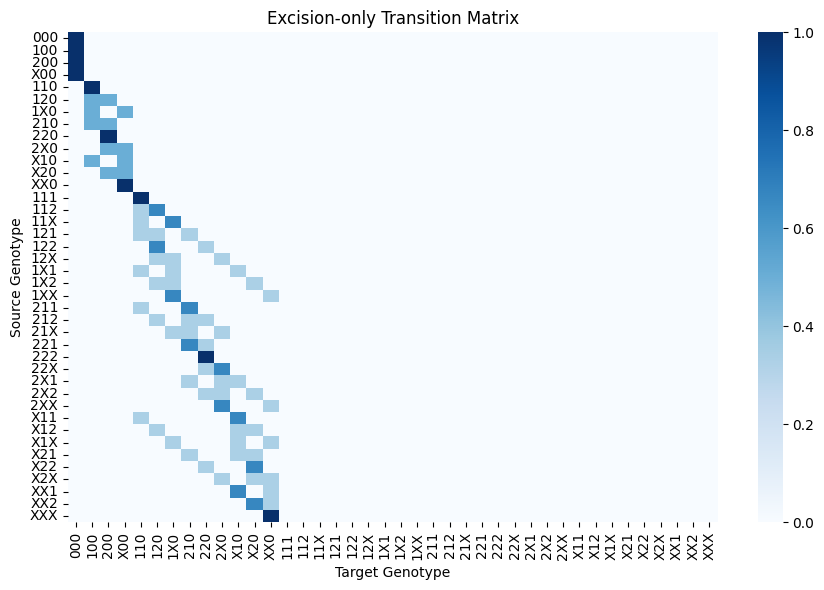

Exporting /content/drive/MyDrive/SYNC_Projects/MI/figures/X_aacA37_aacA45/X_aacA37_aacA45_ExcIntMatrix.pdf


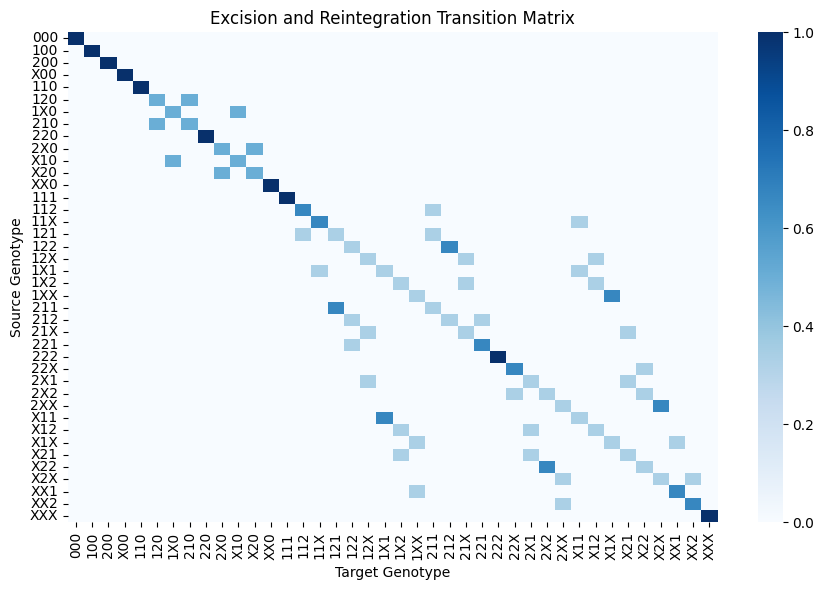

Exporting /content/drive/MyDrive/SYNC_Projects/MI/figures/X_aacA37_aacA45/X_aacA37_aacA45_DupMatrix.pdf


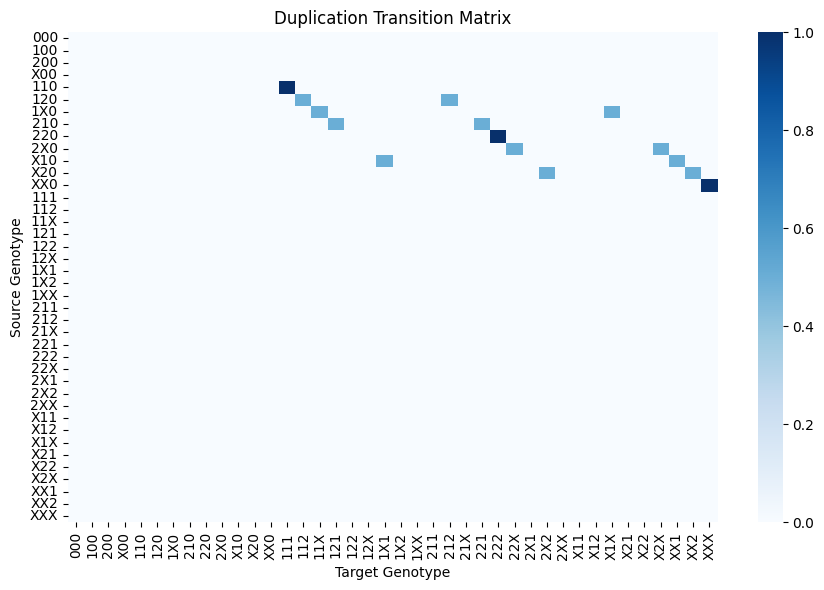

In [111]:


def plot_transition_matrix(matrix, labels_genotypes, title, num_cassettes, outPath):
    """Plots a heatmap of the transition matrix with labeled genotypes."""
    # Format genotype labels with 'X' for the highest cassette and '00' for empty genotypes
    #labels_genotypes = [format_genotype_label(g, num_cassettes) for g in genotypes]

    fig, ax = plt.subplots(figsize=(3*num_cassettes, 2*num_cassettes))
    sns.heatmap(matrix, annot=False, cmap="Blues", xticklabels=labels_genotypes, yticklabels=labels_genotypes, ax=ax)

    ax.set_title(title)
    ax.set_xlabel("Target Genotype")
    ax.set_ylabel("Source Genotype")

    # Center tick positions
    ax.set_xticks(np.arange(len(labels_genotypes)) + 0.5)
    ax.set_yticks(np.arange(len(labels_genotypes)) + 0.5)
    ax.set_xticklabels(labels_genotypes, rotation=90, ha='center')
    ax.set_yticklabels(labels_genotypes, rotation=0)

    plt.tight_layout()

    # Save or show plot
    if outPath:
        plt.savefig(outPath, format='pdf', bbox_inches='tight', pad_inches=0.2)
        print(f"Exporting {outPath}")
        plt.show()
        plt.close()
    else:
        plt.show()


# Plot the excision-only and excision-reintegration matrices
outPath=f"{dirNameFigures}/X_{test_gene_labels[0]}_{test_gene_labels[1]}_ExcMatrix.pdf"
plot_transition_matrix(M_exc, labels_genotypes, "Excision-only Transition Matrix", num_cassettes, outPath=outPath)


outPath=f"{dirNameFigures}/X_{test_gene_labels[0]}_{test_gene_labels[1]}_ExcIntMatrix.pdf"
plot_transition_matrix(M_int, labels_genotypes, "Excision and Reintegration Transition Matrix", num_cassettes, outPath=outPath)



outPath=f"{dirNameFigures}/X_{test_gene_labels[0]}_{test_gene_labels[1]}_DupMatrix.pdf"
plot_transition_matrix(M_dup, labels_genotypes, "Duplication Transition Matrix", num_cassettes, outPath=outPath)


Exporting /content/drive/MyDrive/SYNC_Projects/MI/figures/X_aacA37_aacA45/X_aacA37_aacA45_CombinedMatrix.pdf


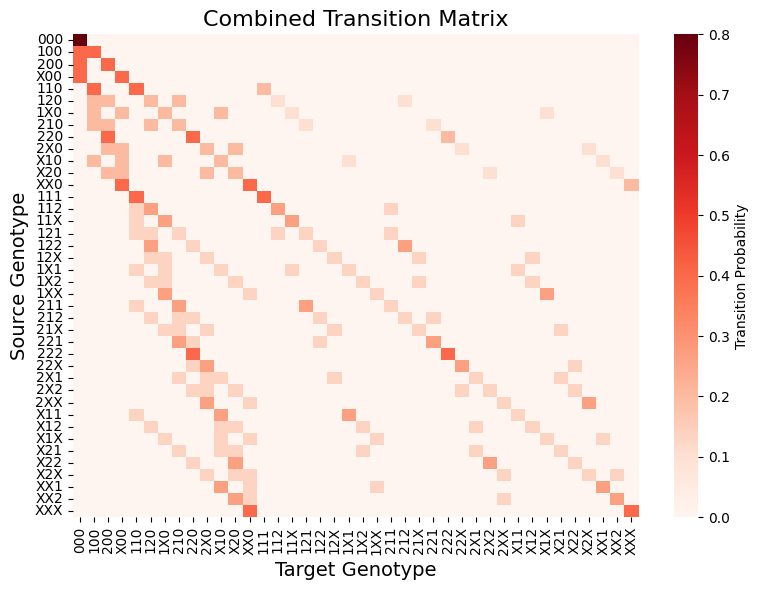

In [112]:
def merge_matrices_with_diagonal_weighted(*matrices, weights=None):
    """
    Merges multiple matrices with specified weights.
    Includes diagonal values representing the probability of remaining in the same genotype.

    Parameters:
        matrices (ndarray): Transition matrices to be merged (e.g., M_exc, M_int, M_dup).
        weights (list of float, optional): Weights for each matrix. If None, assigns equal weights.

    Returns:
        ndarray: Weighted merged matrix with diagonal values included.
    """
    if not matrices:
        raise ValueError("At least one matrix must be provided.")

    num_matrices = len(matrices)

    # Validate matrix dimensions
    matrix_shape = matrices[0].shape
    if not all(matrix.shape == matrix_shape for matrix in matrices):
        raise ValueError("All matrices must have the same dimensions.")

    # Assign equal weights if not provided
    if weights is None:
        weights = [1 / num_matrices] * num_matrices
    elif len(weights) != num_matrices:
        raise ValueError("Number of weights must match the number of matrices.")

    # Ensure weights sum to 1
    total_weight = sum(weights)
    weights = [w / total_weight for w in weights]

    # Merge the matrices with weights
    merged_matrix = sum(w * matrix for w, matrix in zip(weights, matrices))

    # Add diagonal probabilities (self-transitions)
    diagonal_weights = [w * np.diagonal(matrix) for w, matrix in zip(weights, matrices)]
    np.fill_diagonal(merged_matrix, sum(diagonal_weights))

    return merged_matrix



def plot_combined_transition_matrix(matrix, labels_genotypes, title, outPath):
    """
    Plots a heatmap of the combined transition matrix with labeled genotypes.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(
        matrix,
        annot=False,
        cmap="Reds",
        xticklabels=labels_genotypes,
        yticklabels=labels_genotypes,
        ax=ax,
        cbar_kws={"label": "Transition Probability"}
    )

    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Target Genotype", fontsize=14)
    ax.set_ylabel("Source Genotype", fontsize=14)

    # Center tick positions
    ax.set_xticks(np.arange(len(labels_genotypes)) + 0.5)
    ax.set_yticks(np.arange(len(labels_genotypes)) + 0.5)
    ax.set_xticklabels(labels_genotypes, rotation=90, ha='center', fontsize=10)
    ax.set_yticklabels(labels_genotypes, rotation=0, fontsize=10)

    plt.tight_layout()

    # Save or show plot
    if outPath:
        plt.savefig(outPath, format='pdf', bbox_inches='tight', pad_inches=0.2)
        print(f"Exporting {outPath}")
        plt.show()
        plt.close()
    else:
        plt.show()


weights = [0.4, 0.4, 0.2]  # 40% weight to M_exc, 40% to M_int, and 20% to M_dup
M = merge_matrices_with_diagonal_weighted(M_exc, M_int, M_dup, weights=[0.4, 0.4, 0.2])


# Plot the merged matrix
outPath=f"{dirNameFigures}/X_{test_gene_labels[0]}_{test_gene_labels[1]}_CombinedMatrix.pdf"
plot_combined_transition_matrix(M, labels_genotypes, f"Combined Transition Matrix", outPath=outPath)


In [113]:
def construct_accessibility_tree(initial_genotype, M):
    """
    Constructs a tree of accessible genotypes from an initial genotype.

    Parameters:
        initial_genotype (int): Index of the initial genotype (row/column index in M).
        M (ndarray): Combined transition matrix (values > 0 indicate possible transitions).

    Returns:
        tree (dict): A dictionary representing the tree structure.
                     Keys are genotypes, and values are lists of accessible genotypes.
    """
    # Initialize the tree as a dictionary of lists
    tree = defaultdict(list)
    visited = set()  # Keep track of visited genotypes
    queue = deque([initial_genotype])  # Start BFS/DFS from the initial genotype

    while queue:
        current = queue.popleft()  # BFS: use popleft()
        visited.add(current)

        # Ensure the current genotype is in the tree
        if current not in tree:
            tree[current] = []

        # Find neighbors with transition probabilities > 0
        neighbors = np.where(M[current] > 0)[0]

        for neighbor in neighbors:
            # Add the neighbor to the tree
            tree[current].append(neighbor)
            if neighbor not in visited and neighbor not in queue:
                queue.append(neighbor)  # Add the neighbor for further exploration

    return dict(tree)


def construct_accessibility_tree_by_label(initial_genotype_label, labels_genotypes, M):
    """
    Constructs a tree of accessible genotypes from an initial genotype using labels.

    Parameters:
        initial_genotype_label (str): Label of the initial genotype (e.g., '1X0').
        labels_genotypes (list): List of genotype labels corresponding to rows/columns in M.
        M (ndarray): Combined transition matrix (values > 0 indicate possible transitions).

    Returns:
        tree (dict): A dictionary representing the tree structure.
                     Keys are genotype labels, and values are lists of accessible genotype labels.
    """
    # Map labels to indices for easy lookup
    label_to_index = {label: idx for idx, label in enumerate(labels_genotypes)}
    index_to_label = {idx: label for idx, label in enumerate(labels_genotypes)}

    # Find the index of the initial genotype
    if initial_genotype_label not in label_to_index:
        raise ValueError(f"Initial genotype label '{initial_genotype_label}' not found in labels_genotypes.")

    initial_genotype_index = label_to_index[initial_genotype_label]

    # Use the base function to construct the tree by indices
    tree_indices = construct_accessibility_tree(initial_genotype_index, M)

    # Convert indices to labels
    tree_labels = {index_to_label[key]: [index_to_label[child] for child in children]
                   for key, children in tree_indices.items()}

    return tree_labels


# Construct the tree using the combined matrix
accessibility_tree_labels = construct_accessibility_tree_by_label(
    initial_genotype_label,
    labels_genotypes,
    M
)

# Print the resulting tree
accessible_strains=[]
for genotype, neighbors in accessibility_tree_labels.items():
    print(f"{genotype} -> {neighbors}")


keys_list = list(accessibility_tree_labels.keys())  # Get the list of keys from the dictionary

# Filter strains based on strainID being in keys_list
strains_accessible = [strain for strain in strains if strain['strainID'] in keys_list]
# Filter labels_genotypes to include only those in keys_list
labels_genotypes_accessible = [label for label in labels_genotypes if label in keys_list]

# Print the result
print(labels_genotypes_accessible)



12X -> ['120', '1X0', '2X0', '12X', '21X', 'X12']
120 -> ['100', '200', '120', '210', '112', '212']
1X0 -> ['100', 'X00', '1X0', 'X10', '11X', 'X1X']
2X0 -> ['200', 'X00', '2X0', 'X20', '22X', 'X2X']
21X -> ['1X0', '210', '2X0', '12X', '21X', 'X21']
X12 -> ['120', 'X10', 'X20', '1X2', '2X1', 'X12']
100 -> ['000', '100']
200 -> ['000', '200']
210 -> ['100', '200', '120', '210', '121', '221']
112 -> ['110', '120', '112', '211']
212 -> ['120', '210', '220', '122', '212', '221']
X00 -> ['000', 'X00']
X10 -> ['100', 'X00', '1X0', 'X10', '1X1', 'XX1']
11X -> ['110', '1X0', '11X', 'X11']
X1X -> ['1X0', 'X10', 'XX0', '1XX', 'X1X', 'XX1']
X20 -> ['200', 'X00', '2X0', 'X20', '2X2', 'XX2']
22X -> ['220', '2X0', '22X', 'X22']
X2X -> ['2X0', 'X20', 'XX0', '2XX', 'X2X', 'XX2']
X21 -> ['210', 'X10', 'X20', '1X2', '2X1', 'X21']
1X2 -> ['120', '1X0', 'X20', '1X2', '21X', 'X12']
2X1 -> ['210', '2X0', 'X10', '12X', '2X1', 'X21']
000 -> ['000']
121 -> ['110', '120', '210', '112', '121', '211']
221 -> ['21

Exporting /content/drive/MyDrive/SYNC_Projects/MI/figures/X_aacA37_aacA45/X_aacA37_aacA45_Network.pdf


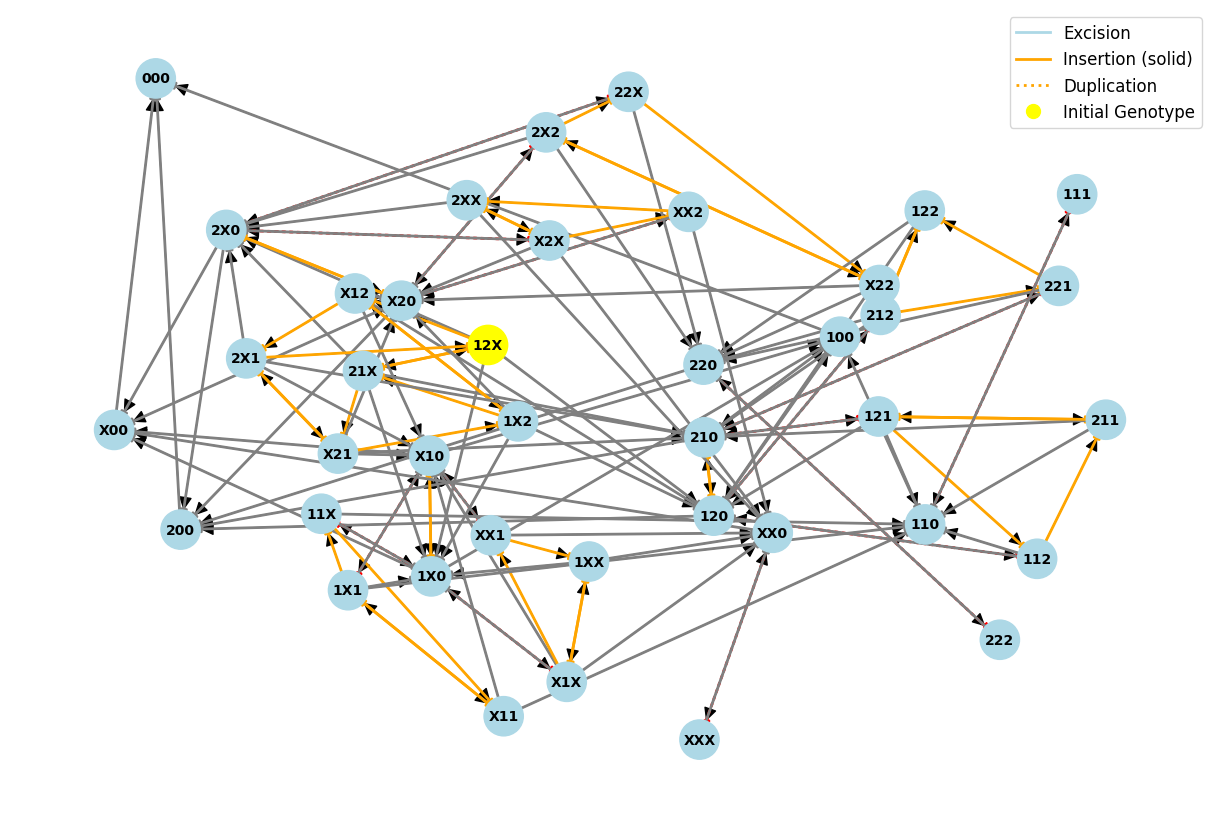

In [114]:
def visualize_accessibility_tree_with_colors_by_label(
    initial_genotype_label, labels_genotypes, M, M_exc, M_int, M_dup, outPath='', k=1.0, iterations=100
):
    """
    Visualizes the accessibility tree using NetworkX and Matplotlib with colored edges
    based on transition source (M_exc, M_int, or M_dup) and highlights the initial genotype node.

    Parameters:
        initial_genotype_label (str): The initial genotype label.
        labels_genotypes (list): List of genotype labels corresponding to the indices.
        M (ndarray): Combined transition matrix.
        M_exc (ndarray): Excision matrix.
        M_int (ndarray): Reintegration matrix.
        M_dup (ndarray): Duplication matrix.
        outPath (str): Output path to save the plot (optional).
        k (float): Ideal distance between nodes in the spring layout.
        iterations (int): Number of iterations for the spring layout algorithm.

    Returns:
        None: Displays the tree graph.
    """
    # Find the index corresponding to the initial_genotype_label
    if initial_genotype_label not in labels_genotypes:
        raise ValueError(f"Initial genotype label '{initial_genotype_label}' not found in labels_genotypes.")
    initial_genotype_index = labels_genotypes.index(initial_genotype_label)

    # Construct the accessibility tree
    tree = construct_accessibility_tree(initial_genotype_index, M)

    # Create a directed graph
    G = nx.DiGraph()
    edge_colors = []  # To store edge colors
    edge_styles = []  # To store edge styles (solid/dotted)

    # Add nodes and edges to the graph, tagging edges with colors and styles
    for parent, children in tree.items():
        parent_label = labels_genotypes[parent]  # Convert index to label
        for child in children:
            if parent != child:  # Skip self-loops
                child_label = labels_genotypes[child]  # Convert index to label
                G.add_edge(parent_label, child_label)

                # Determine the source of the transition
                if M_dup[parent, child] > 0:
                    edge_colors.append('red')  # From M_dup
                    edge_styles.append('dotted')  # Dotted for duplications
                elif M_exc[parent, child] > 0:
                    edge_colors.append('lightblue')  # From M_exc
                    edge_styles.append('solid')  # Solid for excision
                elif M_int[parent, child] > 0:
                    edge_colors.append('orange')  # From M_int
                    edge_styles.append('solid')  # Solid for insertion
                else:
                    edge_colors.append('gray')  # Fallback
                    edge_styles.append('solid')

    # Draw the graph
    plt.figure(figsize=(12, 8))

    # Use the spring layout with adjusted elasticity
    pos = nx.spring_layout(G, seed=42, k=k, iterations=iterations)

    # Draw nodes with a special color for the initial genotype
    node_colors = ['yellow' if node == initial_genotype_label else 'lightblue' for node in G.nodes()]
    nx.draw(
        G, pos, with_labels=True, node_size=800, node_color=node_colors,
        font_size=10, font_weight="bold", arrowsize=20
    )

    # Draw edges with different colors and styles
    for (u, v), color, style in zip(G.edges(), edge_colors, edge_styles):
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color=color, style=style, width=2)

    # Add a legend for edge colors and styles
    legend_elements = [
        plt.Line2D([0], [0], color='lightblue', lw=2, label='Excision'),
        plt.Line2D([0], [0], color='orange', lw=2, label='Insertion (solid)'),
        plt.Line2D([0], [0], color='orange', lw=2, linestyle='dotted', label='Duplication'),
        plt.Line2D([0], [0], color='yellow', marker='o', markersize=10, label='Initial Genotype', lw=0),
    ]
    plt.legend(handles=legend_elements, loc='best', fontsize=12)

    # Save or show plot
    if outPath:
        plt.savefig(outPath, format='pdf', bbox_inches='tight', pad_inches=0.2)
        print(f"Exporting {outPath}")
        plt.show()
        plt.close()
    else:
        plt.show()

# Example usage
outPath = f"{dirNameFigures}/X_{test_gene_labels[0]}_{test_gene_labels[1]}_Network.pdf"
visualize_accessibility_tree_with_colors_by_label(
    initial_genotype_label, labels_genotypes, M, M_exc, M_int, M_dup, outPath=outPath, k=3.0, iterations=200
)


Exporting /content/drive/MyDrive/SYNC_Projects/MI/figures/X_aacA37_aacA45/X_aacA37_aacA45_NetworkM.pdf


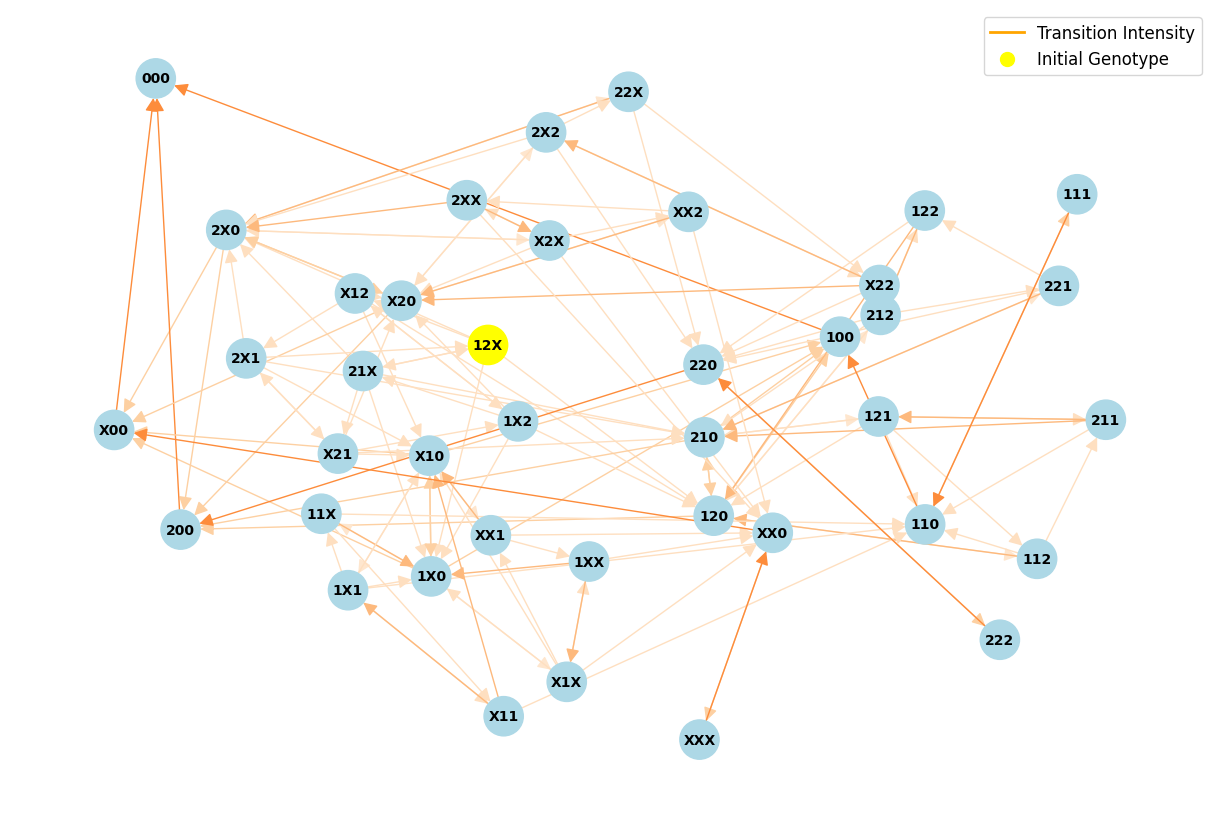

In [115]:
def visualize_accessibility_tree_combined(initial_genotype_label, labels_genotypes, M, outPath='', k=1.0, iterations=100):
    """
    Visualizes the accessibility tree using NetworkX and Matplotlib with colored edges
    based on transition probabilities from the combined matrix and highlights the initial genotype node.

    Parameters:
        initial_genotype_label (str): The initial genotype label.
        labels_genotypes (list): List of genotype labels corresponding to the indices.
        M (ndarray): Combined transition matrix.
        outPath (str): Path to save the plot (optional).
        k (float): Ideal distance between nodes in the spring layout.
        iterations (int): Number of iterations for the spring layout algorithm.

    Returns:
        None: Displays the tree graph.
    """
    # Find the index corresponding to the initial_genotype_label
    if initial_genotype_label not in labels_genotypes:
        raise ValueError(f"Initial genotype label '{initial_genotype_label}' not found in labels_genotypes.")
    initial_genotype_index = labels_genotypes.index(initial_genotype_label)

    # Construct the accessibility tree
    tree = construct_accessibility_tree(initial_genotype_index, M)

    # Create a directed graph
    G = nx.DiGraph()
    edge_colors = []  # To store edge colors

    # Add nodes and edges to the graph, tagging edges with colors
    for parent, children in tree.items():
        parent_label = labels_genotypes[parent]  # Convert index to label
        for child in children:
            if parent != child:  # Skip self-loops
                child_label = labels_genotypes[child]  # Convert index to label
                G.add_edge(parent_label, child_label)

                # Edge color intensity based on transition probability
                edge_colors.append(M[parent, child])

    # Draw the graph
    plt.figure(figsize=(12, 8))

    # Use the spring layout with adjustable elasticity
    pos = nx.spring_layout(G, seed=42, k=k, iterations=iterations)

    # Draw nodes with a special color for the initial genotype
    node_colors = ['yellow' if node == initial_genotype_label else 'lightblue' for node in G.nodes()]
    nx.draw(
        G, pos, with_labels=True, node_size=800, node_color=node_colors,
        font_size=10, font_weight="bold", arrowsize=20, edge_color=edge_colors,
        edge_cmap=plt.cm.Oranges, edge_vmin=0, edge_vmax=np.max(M)
    )

    # Add a legend for node colors
    legend_elements = [
        plt.Line2D([0], [0], color='orange', lw=2, label='Transition Intensity'),
        plt.Line2D([0], [0], color='yellow', marker='o', markersize=10, label='Initial Genotype', lw=0),
    ]
    plt.legend(handles=legend_elements, loc='best', fontsize=12)

    # Save or show plot
    if outPath:
        plt.savefig(outPath, format='pdf', bbox_inches='tight', pad_inches=0.2)
        print(f"Exporting {outPath}")
        plt.show()
        plt.close()
    else:
        plt.show()


# Example usage with elasticity adjustments
outPath = f"{dirNameFigures}/X_{test_gene_labels[0]}_{test_gene_labels[1]}_NetworkM.pdf"
visualize_accessibility_tree_combined(
    initial_genotype_label, labels_genotypes, M, outPath=outPath, k=3.0, iterations=200
)


Exporting /content/drive/MyDrive/SYNC_Projects/MI/figures/X_aacA37_aacA45/X_aacA37_aacA45_AccessibleMatrix.pdf


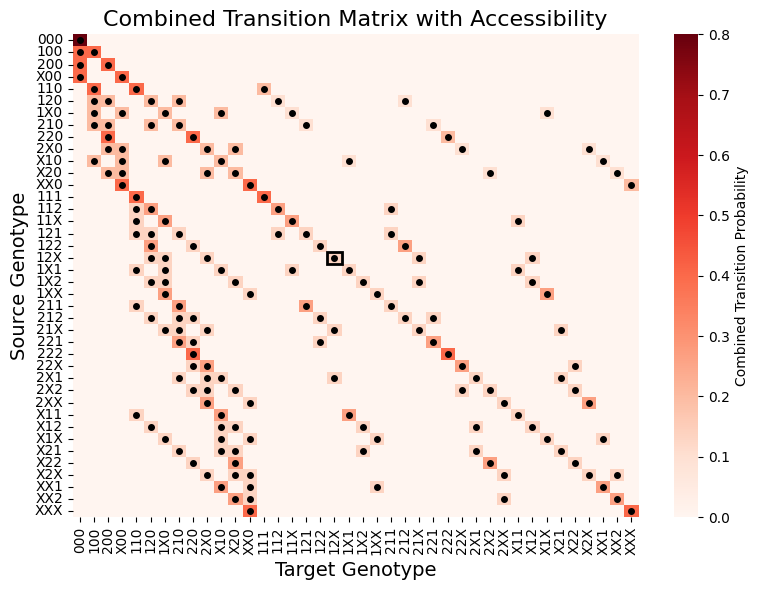

In [116]:
def plot_combined_transition_matrix_with_accessibility(matrix, labels_genotypes, title, accessibility_tree=None, initial_genotype_label=None, outPath=''):
    """
    Plots a heatmap of the combined transition matrix with optional accessibility and initial genotype highlights.

    Parameters:
        matrix (ndarray): Combined transition matrix to visualize.
        labels_genotypes (list): List of genotype labels.
        title (str): Title for the heatmap.
        accessibility_tree (dict, optional): Accessibility tree where keys are genotype labels and values are accessible labels.
                                             If None or empty, accessibility is ignored.
        initial_genotype_label (str, optional): The initial genotype label. If None, no specific genotype is highlighted.
    """

    # Check if accessibility_tree is provided and not empty
    has_accessibility = accessibility_tree is not None and bool(accessibility_tree)

    # Determine accessible genotypes from the accessibility tree (if provided and non-empty)
    accessible_genotypes = set()
    if has_accessibility:
        accessible_genotypes = set(accessibility_tree.keys())
        for key, children in accessibility_tree.items():
            accessible_genotypes.update(children)

    # Plot the heatmap
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(
        matrix,
        annot=False,
        cmap="Reds",
        xticklabels=labels_genotypes,
        yticklabels=labels_genotypes,
        ax=ax,
        cbar_kws={"label": "Combined Transition Probability"}
    )

    # Add dots for accessible genotypes if accessibility_tree is provided and non-empty
    if has_accessibility:
        for i, source_genotype in enumerate(labels_genotypes):
            for j, target_genotype in enumerate(labels_genotypes):
                if source_genotype in accessibility_tree and target_genotype in accessibility_tree[source_genotype]:
                    ax.plot(j + 0.5, i + 0.5, 'o', color='black', markersize=4)

    # Highlight the initial genotype if provided
    if initial_genotype_label:
        if initial_genotype_label in labels_genotypes:
            initial_index = labels_genotypes.index(initial_genotype_label)
            ax.add_patch(plt.Rectangle((initial_index, initial_index), 1, 1, fill=False, edgecolor='black', lw=2))
        else:
            raise ValueError(f"Initial genotype label '{initial_genotype_label}' not found in labels_genotypes.")

    # Add titles and labels
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Target Genotype", fontsize=14)
    ax.set_ylabel("Source Genotype", fontsize=14)

    # Center tick positions
    ax.set_xticks(np.arange(len(labels_genotypes)) + 0.5)
    ax.set_yticks(np.arange(len(labels_genotypes)) + 0.5)
    ax.set_xticklabels(labels_genotypes, rotation=90, ha='center', fontsize=10)
    ax.set_yticklabels(labels_genotypes, rotation=0, fontsize=10)

    plt.tight_layout()

    # Save or show plot
    if outPath:
        plt.savefig(outPath, format='pdf', bbox_inches='tight', pad_inches=0.2)
        print(f"Exporting {outPath}")
        plt.show()
        plt.close()
    else:
        plt.show()




outPath=f"{dirNameFigures}/X_{test_gene_labels[0]}_{test_gene_labels[1]}_AccessibleMatrix.pdf"
plot_combined_transition_matrix_with_accessibility(
    M,
    labels_genotypes,
    "Combined Transition Matrix with Accessibility",
    accessibility_tree=accessibility_tree_labels,
    initial_genotype_label=initial_genotype_label,
    outPath=outPath
)


# Gillespie algorithm

The Gillespie algorithm is implemented to simulate bacterial population dynamics in multispecies systems, incorporating resource competition, antibiotic effects, and genetic reshuffling based on a combined transition matrix. This approach provides a stochastic framework to model the interaction of evolutionary and ecological processes at the population level.

#### Key Features

1. **Population Dynamics**  
   Each bacterial strain's growth and death are modeled based on resource availability and antibiotic concentration. Growth rates are adjusted using Monod kinetics, while antibiotic-induced death rates are determined by strain-specific half-saturation parameters.

2. **Resource Consumption**  
   Resources are depleted based on the cumulative growth of the population, capturing the competitive dynamics of resource utilization.

3. **Genetic Reshuffling**  
   Strains can transition between genotypes via excision, reintegration, or duplication events. These transitions are governed by a combined transition matrix (`M`) and are modulated by the probability of SOS-induced reshuffling.

4. **Daily Cycles and Dilution**  
   The simulation runs over multiple days, with populations diluted at the end of each day to mimic serial transfer experiments. This allows exploration of long-term evolutionary dynamics under varying conditions.

#### Core Functions

- **`gillespie_multispecies_growth`**  
  Simulates population dynamics over a single day.  
  Parameters include strain-specific growth rates, antibiotic concentration, resource levels, and transition matrices. Outputs are time-series data for populations and resources.


In [117]:
def gillespie_multispecies_growth(
    strains, populations, antibiotic_concentration, initial_resource, simulation_time,
    M, shuffling_rate, max_antibiotic_concentration, p_sos_min, c_mid, k, dt=0.1
):
    """
    Simulates bacterial growth with competition among multiple strains, including genotype transitions
    due to constant shuffling based on the combined transition matrix and SOS response.

    Parameters:
        strains (list): List of strain dictionaries containing strain information.
        populations (list): Initial populations of each strain.
        antibiotic_concentration (float): Current antibiotic concentration.
        initial_resource (float): Initial amount of resource available.
        simulation_time (float): Total simulation time.
        M (ndarray): Combined transition matrix.
        shuffling_rate (float): Base shuffling rate (per unit time).
        max_antibiotic_concentration (float): Maximum antibiotic concentration for SOS induction.
        p_sos_min (float): Minimum reshuffling probability at zero antibiotic concentration.
        c_mid (float): Midpoint concentration of the sigmoid function.
        k (float): Steepness of the sigmoid curve.
        dt (float): Time step for updates.

    Returns:
        tuple: Time values, population dynamics, and resource dynamics.
    """
    num_strains = len(strains)
    strain_labels = [strain['strainID'] for strain in strains]  # Get strain labels for printing

    # Initialize variables for simulation
    t = 0
    R = initial_resource
    t_values = [t]
    population_values = [populations.copy()]
    resource_values = [R]

    while t < simulation_time and np.sum(populations) > 0 and R > 0:
        # Update populations for each strain based on birth and death rates
        for i, strain in enumerate(strains):
            half_saturation_resource = strain['half_saturation_resource']
            half_saturation_antibiotic = strain['half_saturation_antibiotic']

            # Effective birth rate, considering resource limitation
            birth_rate_eff = strain['birth_rate'] * (R / (R + half_saturation_resource))
            birth_rate_eff = max(birth_rate_eff, 0)

            # Expected births and deaths for each strain
            expected_births = max(0, np.random.poisson(birth_rate_eff * populations[i] * dt)) if populations[i] > 0 else 0
            death_rate_eff = strain['death_rate'] * (antibiotic_concentration / (antibiotic_concentration + half_saturation_antibiotic))
            expected_deaths = max(0, np.random.poisson(death_rate_eff * populations[i] * dt)) if populations[i] > 0 else 0

            # Update population for this strain
            populations[i] = max(0, populations[i] + expected_births - expected_deaths)

            # Update resource level based on consumption
            R = max(0, R - expected_births * strain['consumption_rate'])

        # Calculate SOS reshuffling probability based on antibiotic concentration
        p_sos = p_sos_min + (1 - p_sos_min) / (1 + np.exp(-k * (antibiotic_concentration - c_mid)))

        # Apply genotype shuffling based on shuffling_rate and the combined transition matrix
        for i in range(num_strains):
            if populations[i] > 0 and np.random.rand() < p_sos:  # SOS response determines reshuffling
                for j in range(num_strains):
                    transition_prob = shuffling_rate * M[i, j]
                    transition_events = np.random.binomial(populations[i], transition_prob)
                    populations[i] -= transition_events
                    populations[j] += transition_events

        # Update time and store results
        t += dt
        t_values.append(t)
        population_values.append(populations.copy())
        resource_values.append(R)

    return t_values, population_values, resource_values



- **`runSimulation`**  
  Simulates population dynamics over multiple days.  
  Integrates the Gillespie algorithm into a serial dilution framework, tracking daily population densities and resource levels.


In [118]:

def runSimulation(
    M, strains, initial_populations, num_days, antibiotic_concentration, initial_resource,
    simulation_time, dilution=0.1, transition_rate=0.01, dt=0.1,
    p_sos_min=0.1, c_sos=0.5, k_sos=10.0, max_antibiotic_concentration=1.0
):
    """
    Runs a simulation over multiple days with specific strain parameters, using the provided initial populations.

    Parameters:
    strains (list): List of dictionaries for strains with relevant parameters.
    initial_populations (numpy array): Initial population sizes for each strain.
    num_days (int): Number of days to simulate.
    antibiotic_concentration (float): Shared antibiotic concentration.
    initial_resource (float): Shared initial resource concentration.
    simulation_time (float): Duration of each day's simulation.
    dilution (float): Dilution factor applied at the end of each day.
    transition_rate (float): Base rate at which genotype transitions occur.
    dt (float): Time interval for batch updates.
    p_sos_min (float): Minimum reshuffling probability (at zero antibiotic concentration).
    c_sos (float): Midpoint concentration of the sigmoid function for reshuffling probability.
    k_sos (float): Steepness of the sigmoid function.
    max_antibiotic_concentration (float): Maximum antibiotic concentration for SOS induction.

    Returns:
    list: A list of dictionaries containing daily results.
    """
    results = []

    # Initialize populations as a float array to prevent type mismatches
    populations = initial_populations.astype(float)

    for day in range(num_days):
        # Run the simulation for 1 day
        time_points, population_values, resource_values = gillespie_multispecies_growth(
            strains, populations, antibiotic_concentration, initial_resource, simulation_time,
            M, transition_rate, max_antibiotic_concentration,
            p_sos_min, c_sos, k_sos, dt
        )

        # Save results for the day
        day_results = {
            'day': day + 1,
            'time_points': time_points,
            'final_populations': population_values[-1],  # Last state of populations
            'resource': resource_values[-1]
        }
        results.append(day_results)

        # Apply dilution to the populations for the next day
        populations *= dilution

        # Check if all populations are zero
        if np.all(populations <= 0):
            print(f"All populations went to zero on day {day + 1}. Stopping simulation.")
            break

    return results


In [119]:


def plotPopulationDynamics(results, days, strains, initial_populations, ncol=10):
    """
    Plots the density of each strain over time with the strainID in the legend.

    Parameters:
    results (list of dict): Simulation results with population densities.
    days (list of int): List of days to include in the plot.
    strains (list of dict): List of strains with 'strainID', 'color', and other parameters.
    initial_populations (numpy array): Initial population densities for each strain at day 0.
    ncol (int): Number of columns in the legend, default is 10.
    """
    # Initialize lists to hold time and strain densities
    time_points = [0]  # Start with day 0
    strain_densities = [initial_populations]  # Include initial populations at day 0

    # Extract data for each day in results
    for day_result in results:
        day = day_result['day']
        if day in days:
            # Append time point and final population densities of the day
            time_points.append(day)
            densities = day_result['final_populations']
            strain_densities.append(densities)

    # Convert strain densities to an array for easier indexing
    strain_densities = np.array(strain_densities).T  # Transpose for plotting by strain

    plt.figure(figsize=(12, 6))
    for i, strain in enumerate(strains):
        # Use the assigned color for each strain
        color = strain['color']
        plt.plot(time_points, strain_densities[i], label=strain['strainID'], color=color)

    # Add labels and legend
    plt.xlabel('Time (days)', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.yscale('log')  # Optional: Log scale for density if values vary widely
    plt.legend(fontsize=12, title="Strain ID", loc='upper center', ncol=ncol, bbox_to_anchor=(0.5, -0.15))
    plt.tight_layout()
    plt.ylim([1e3, 1.1 * np.max(strain_densities)])
    plt.show()


## Dose-Response Experiments: Simulation and Visualization

This section focuses on simulating and analyzing the response of bacterial populations to varying antibiotic concentrations. It combines the Gillespie-based simulation framework with a dose-response experimental setup to assess how bacterial strains adapt to and survive under different levels of selective pressure.


In [120]:
def run_doseresponse(
    M, strains, B0, labels_genotypes, initial_genotype_label, num_days,
    initial_resource, simulation_time, dilution_factor, transition_rate, antibiotic_concentrations,
    p_sos_min=0.1, c_sos=0.5, k_sos=10.0, max_antibiotic_concentration=1.0
):
    """
    Runs a dose-response experiment by varying antibiotic concentrations
    and records the final densities of each strain.

    Parameters:
        strains (list): List of strain dictionaries containing strain information.
        labels_genotypes (list): List of genotype labels corresponding to strains.
        initial_genotype_label (str): Label of the initial genotype for the simulation.
        num_days (int): Number of days to run the simulation.
        initial_resource (float): Initial amount of resource available.
        simulation_time (float): Total simulation time for each day.
        dilution_factor (float): Dilution factor applied after each day of growth.
        transition_rate (float): Transition rate for mutation or other processes.
        antibiotic_concentrations (list): List of antibiotic concentrations to test.
        p_sos_min (float): Minimum reshuffling probability (at zero antibiotic concentration).
        c_sos (float): Midpoint concentration of the sigmoid function for reshuffling probability.
        k_sos (float): Steepness of the sigmoid function.
        max_antibiotic_concentration (float): Maximum antibiotic concentration for SOS induction.

    Returns:
        pd.DataFrame: A DataFrame containing the final densities of each strain at each antibiotic concentration.
    """
    # Prepare a list to store results
    dose_response_results = []

    # Loop over each antibiotic concentration
    for antibiotic_concentration in antibiotic_concentrations:
        # Define initial populations for each strain
        if initial_genotype_label is None:
            initial_populations = np.array([B0] * len(strains))
        else:
            initial_populations = np.array([0] * len(strains))
            genotype_to_find = initial_genotype_label
            index_of_genotype = labels_genotypes.index(genotype_to_find) if genotype_to_find in labels_genotypes else None
            initial_populations[index_of_genotype] = B0

        # Run the simulation
        results = runSimulation(
            M,
            strains=strains,
            initial_populations=initial_populations,
            num_days=num_days,
            antibiotic_concentration=antibiotic_concentration,
            initial_resource=initial_resource,
            simulation_time=simulation_time,
            dilution=dilution_factor,
            transition_rate=transition_rate,
            p_sos_min=p_sos_min,
            c_sos=c_sos,
            k_sos=k_sos,
            max_antibiotic_concentration=max_antibiotic_concentration
        )

        # Extract the final populations for each strain
        final_populations = results[-1]['final_populations']

        # Store results in the list
        for strain, final_density in zip(strains, final_populations):
            dose_response_results.append({
                'Antibiotic_Concentration': antibiotic_concentration,
                'Strain_ID': strain['strainID'],
                'Final_Density': final_density
            })

    # Convert the results into a pandas DataFrame
    return pd.DataFrame(dose_response_results)



def plot_doseresponse(dose_response_df, strains, ncol=10, outPath=''):
    """
    Plots the dose-response curve for each strain showing the final density as a function of antibiotic concentration.

    Parameters:
        dose_response_df (pd.DataFrame): DataFrame containing the results of the dose-response experiment.
        strains (list): List of strain dictionaries containing strain information (including colors).
        ncol (int): Number of columns for the legend.

    Returns:
        None: Displays the dose-response plot.
    """
    # Map strain IDs to their colors
    strain_colors = {strain['strainID']: strain['color'] for strain in strains}

    # Create a plot for each strain
    plt.figure(figsize=(12, 6))
    for strain_id in dose_response_df['Strain_ID'].unique():
        # Filter the DataFrame for the current strain
        strain_data = dose_response_df[dose_response_df['Strain_ID'] == strain_id]

        # Plot dose-response curve
        plt.plot(
            strain_data['Antibiotic_Concentration'],
            strain_data['Final_Density'],
            label=f"{strain_id}",
            color=strain_colors.get(strain_id, "black"),  # Default to black if no color is found
            marker='o'
        )

    # Add labels, legend, and title
    plt.yscale('log')  # Log scale for antibiotic concentrations
    plt.xlabel('Antibiotic Concentration', fontsize=16)
    plt.ylabel('Final Density', fontsize=16)
    plt.grid(False)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # Place legend below the plot in multiple columns
    plt.legend(
        title="Strain ID",
        fontsize=10,
        ncol=ncol,
        loc='upper center',
        bbox_to_anchor=(0.5, -0.15)
    )

    # Adjust layout to accommodate the legend
    plt.tight_layout()


    # Save or show plot
    if outPath:
        filename = f"{outPath}_doseResponse.pdf"
        plt.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0.2)
        print(f"Exporting {filename}")
        plt.show()
        plt.close()
    else:
        plt.show()


### Mixed population (all genotypes)

Exporting /content/drive/MyDrive/SYNC_Projects/MI/figures/X_aacA37_aacA45/X_aacA37_aacA45_all_doseResponse.pdf


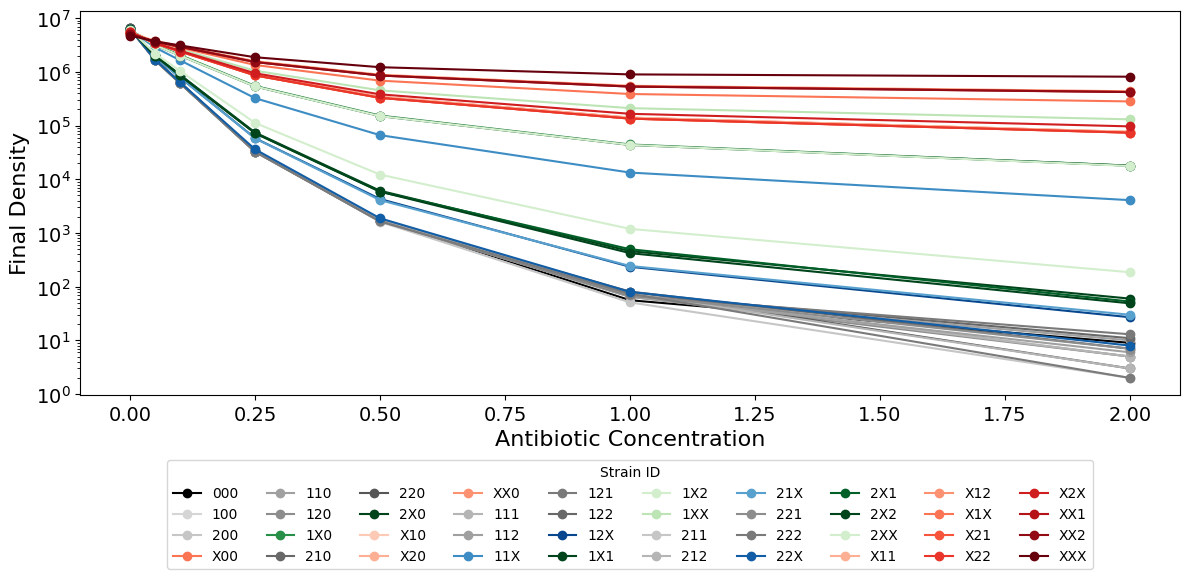

In [121]:

# Define antibiotic concentrations for the dose-response experiment
antibiotic_concentrations = [0.0, 0.05, 0.1, 0.25, 0.5, 1.0, 2.0]  # Example doses

# Run the dose-response experiment
dose_response_df = run_doseresponse(
    M,
    strains=strains,
    B0=B0,
    labels_genotypes=labels_genotypes,
    initial_genotype_label=None,
    num_days=1, #single day
    initial_resource=initial_resource,
    simulation_time=simulation_time,
    dilution_factor=dilution_factor,
    transition_rate=0, #no transitions
    p_sos_min=p_sos_min,
    c_sos=c_sos,
    k_sos=k_sos,
    antibiotic_concentrations=antibiotic_concentrations
)

# Plot the dose-response results
outPath='%s_all'%(file_name_figures)
plot_doseresponse(dose_response_df=dose_response_df, strains=strains, ncol=10, outPath=outPath)



### Mixed population (accessible genotypes)

Exporting /content/drive/MyDrive/SYNC_Projects/MI/figures/X_aacA37_aacA45/X_aacA37_aacA45_accessible_doseResponse.pdf


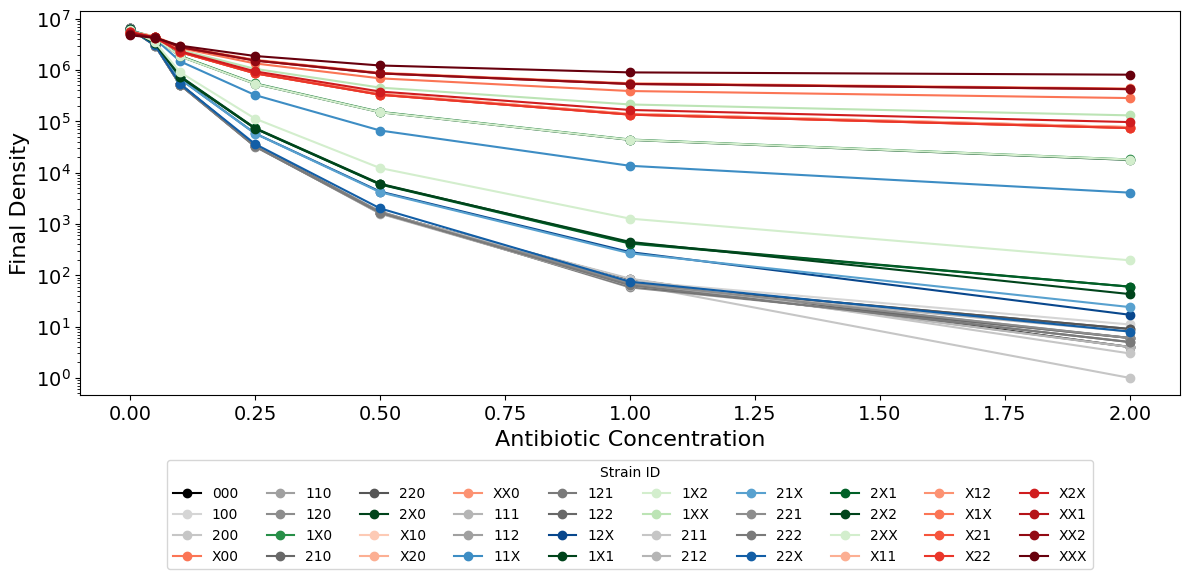

In [122]:

# Define antibiotic concentrations for the dose-response experiment
antibiotic_concentrations = [0.0, 0.05, 0.1, 0.25, 0.5, 1.0, 2.0]  # Example doses

# Run the dose-response experiment
dose_response_accessible_df = run_doseresponse(
    M,
    strains=strains_accessible,
    B0=B0,
    labels_genotypes=labels_genotypes_accessible,
    initial_genotype_label=None,  # All accessible genotypes
    num_days=1, #single day
    initial_resource=initial_resource,
    simulation_time=simulation_time,
    dilution_factor=dilution_factor,
    transition_rate=0, #transition_rate,
    p_sos_min=p_sos_min,
    c_sos=c_sos,
    k_sos=k_sos,
    antibiotic_concentrations=antibiotic_concentrations
)

# Plot the dose-response results
outPath='%s_accessible'%(file_name_figures)
plot_doseresponse(dose_response_df=dose_response_accessible_df, strains=strains_accessible, outPath=outPath)


### Clonal initial density

Exporting /content/drive/MyDrive/SYNC_Projects/MI/figures/X_aacA37_aacA45/X_aacA37_aacA45_clonal_doseResponse.pdf


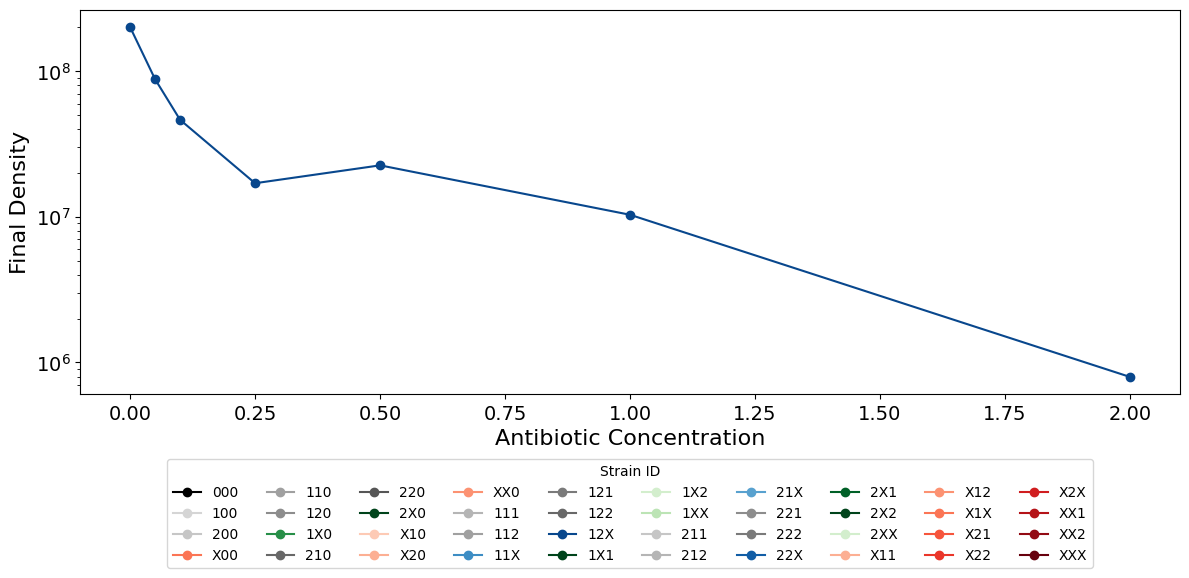

In [123]:

# Define antibiotic concentrations for the dose-response experiment
antibiotic_concentrations = [0.0, 0.05, 0.1, 0.25, 0.5, 1.0, 2.0]  # Example doses

# Run the dose-response experiment
dose_response_clonal_df = run_doseresponse(
    M,
    strains=strains_accessible,
    B0=B0,
    labels_genotypes=labels_genotypes_accessible,
    initial_genotype_label=initial_genotype_label,  # Clonal initial genotype
    num_days=1, #single day
    initial_resource=initial_resource,
    simulation_time=simulation_time,
    dilution_factor=dilution_factor,
    transition_rate=0, #no transitions
    p_sos_min=p_sos_min,
    c_sos=c_sos,
    k_sos=k_sos,
    antibiotic_concentrations=antibiotic_concentrations
)

# Plot the dose-response results
outPath='%s_clonal'%(file_name_figures)
plot_doseresponse(dose_response_df=dose_response_clonal_df, strains=strains_accessible, outPath=outPath)


### Pairwise Competitive Fitness

This section focuses on the calculation of pairwise relative fitness values between bacterial genotypes based on their growth dynamics in competitive environments. The methodology is designed to evaluate the relative success of genotypes under specific environmental conditions by comparing their final densities after direct competition.




In [124]:
def compute_pairwise_fitness(args):
    """
    Helper function to compute relative fitness for a single pair of genotypes.
    Includes diagnostic print statements with densities in scientific notation.
    """
    i, j, M, strains, labels_genotypes, accessible_indices, num_days, initial_resource, simulation_time, \
    dilution_factor, transition_rate, antibiotic_concentration, initial_population_size, p_sos_min, c_sos, k_sos, max_antibiotic_concentration = args

    # Initialize populations
    initial_populations = np.zeros(len(labels_genotypes))
    initial_populations[accessible_indices[i]] = initial_population_size
    initial_populations[accessible_indices[j]] = initial_population_size

    strain_1_label = labels_genotypes[accessible_indices[i]]
    strain_2_label = labels_genotypes[accessible_indices[j]]

    #print(f"Running simulation for {strain_1_label} vs {strain_2_label}...")

    # Run the simulation
    results = runSimulation(
        M,
        strains=strains,
        initial_populations=initial_populations,
        num_days=num_days,
        antibiotic_concentration=antibiotic_concentration,
        initial_resource=initial_resource,
        simulation_time=simulation_time,
        dilution=dilution_factor,
        transition_rate=transition_rate,
        p_sos_min=p_sos_min,
        c_sos=c_sos,
        k_sos=k_sos,
        max_antibiotic_concentration=max_antibiotic_concentration
    )

    # Extract final densities
    strain_1_final_density = results[-1]['final_populations'][accessible_indices[i]]
    strain_2_final_density = results[-1]['final_populations'][accessible_indices[j]]


    # Compute relative fitness
    if strain_1_final_density > 0 and strain_2_final_density > 0:
        relative_fitness = (
            (strain_2_final_density / initial_population_size) /
            (strain_1_final_density / initial_population_size)
        )
    else:
        relative_fitness = np.inf if strain_2_final_density == 0 else 0

    if relative_fitness>2:
      relative_fitness=2 #tmp

    print(f"{strain_1_label}->{strain_2_label} ({strain_1_final_density:.2e}->{strain_2_final_density:.2e}) : {relative_fitness:.4f}")

    return i, j, relative_fitness



def compute_relative_fitness_matrix_for_accessible_parallel(
    M, strains, labels_genotypes, num_days, initial_resource, simulation_time, dilution_factor,
    transition_rate, antibiotic_concentration, accessibility_tree, p_sos_min=0.1, c_sos=0.5, k_sos=10.0, max_antibiotic_concentration=1.0
):
    """
    Computes the relative fitness matrix for genotypes present in the accessibility tree using log2-based relative fitness.
    Parallelized version.
    """
    # Get accessible genotypes and map indices
    accessible_genotypes = set(accessibility_tree.keys())
    for key, children in accessibility_tree.items():
        accessible_genotypes.update(children)
    accessible_genotypes = sorted(accessible_genotypes)
    accessible_indices = [labels_genotypes.index(genotype) for genotype in accessible_genotypes]

    num_accessible = len(accessible_indices)
    relative_fitness_matrix = np.ones((num_accessible, num_accessible))
    initial_population_size = 1e6

    # Prepare arguments for parallel processing
    tasks = [
        (
            i, j, M, strains, labels_genotypes, accessible_indices, num_days,
            initial_resource, simulation_time, dilution_factor, transition_rate,
            antibiotic_concentration, initial_population_size, p_sos_min, c_sos, k_sos, max_antibiotic_concentration
        )
        for i in range(num_accessible) for j in range(num_accessible) if i != j
    ]

    # Run tasks in parallel
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(compute_pairwise_fitness, tasks))

    # Fill the relative fitness matrix with results
    for i, j, fitness in results:
        relative_fitness_matrix[i, j] = fitness

    return relative_fitness_matrix, accessible_genotypes


# Example usage
relative_fitness_matrix_nodrug, accessible_genotypes = compute_relative_fitness_matrix_for_accessible_parallel(
    M,
    strains=strains,
    labels_genotypes=labels_genotypes,
    num_days=1, #single day
    initial_resource=initial_resource,
    simulation_time=simulation_time,
    dilution_factor=dilution_factor,
    transition_rate=0.0, #No transition for competition experiments
    antibiotic_concentration=0.0,  # No drug
    accessibility_tree=accessibility_tree_labels,
    p_sos_min=p_sos_min, c_sos=c_sos, k_sos=k_sos, max_antibiotic_concentration=max_antibiotic_concentration
)


000->100 (1.02e+08->9.95e+07) : 0.9709
000->110 (1.02e+08->9.95e+07) : 0.9709
000->112 (1.02e+08->9.97e+07) : 0.9749
000->111 (1.02e+08->9.97e+07) : 0.9749
000->11X (1.10e+08->9.22e+07) : 0.8404
000->120 (1.03e+08->9.94e+07) : 0.9694
000->121 (1.02e+08->9.95e+07) : 0.9712
000->122 (1.03e+08->9.95e+07) : 0.9705
000->12X (1.04e+08->9.84e+07) : 0.9495
000->1X0 (1.13e+08->8.90e+07) : 0.7871
000->1X1 (1.13e+08->8.91e+07) : 0.7886
000->1XX (1.21e+08->8.11e+07) : 0.6705
000->1X2 (1.13e+08->8.89e+07) : 0.7860
000->200 (1.02e+08->9.95e+07) : 0.9714
000->210 (1.02e+08->9.95e+07) : 0.9712
000->211 (1.02e+08->9.96e+07) : 0.9730
000->212 (1.03e+08->9.93e+07) : 0.9677
000->21X (1.04e+08->9.84e+07) : 0.9505
000->220 (1.03e+08->9.95e+07) : 0.9700
000->221 (1.02e+08->9.95e+07) : 0.9712
000->222 (1.02e+08->9.96e+07) : 0.9718
000->22X (1.03e+08->9.93e+07) : 0.9677
000->2X0 (1.04e+08->9.78e+07) : 0.9393
000->2X1 (1.04e+08->9.79e+07) : 0.9400000->2X2 (1.04e+08->9.78e+07) : 0.9381

000->2XX (1.05e+08->9.65e

Colorbar limits: vmin=0.00, vmax=2.00
Exporting /content/drive/MyDrive/SYNC_Projects/MI/figures/X_aacA37_aacA45/X_aacA37_aacA45_A0_fitnessMatrix.pdf


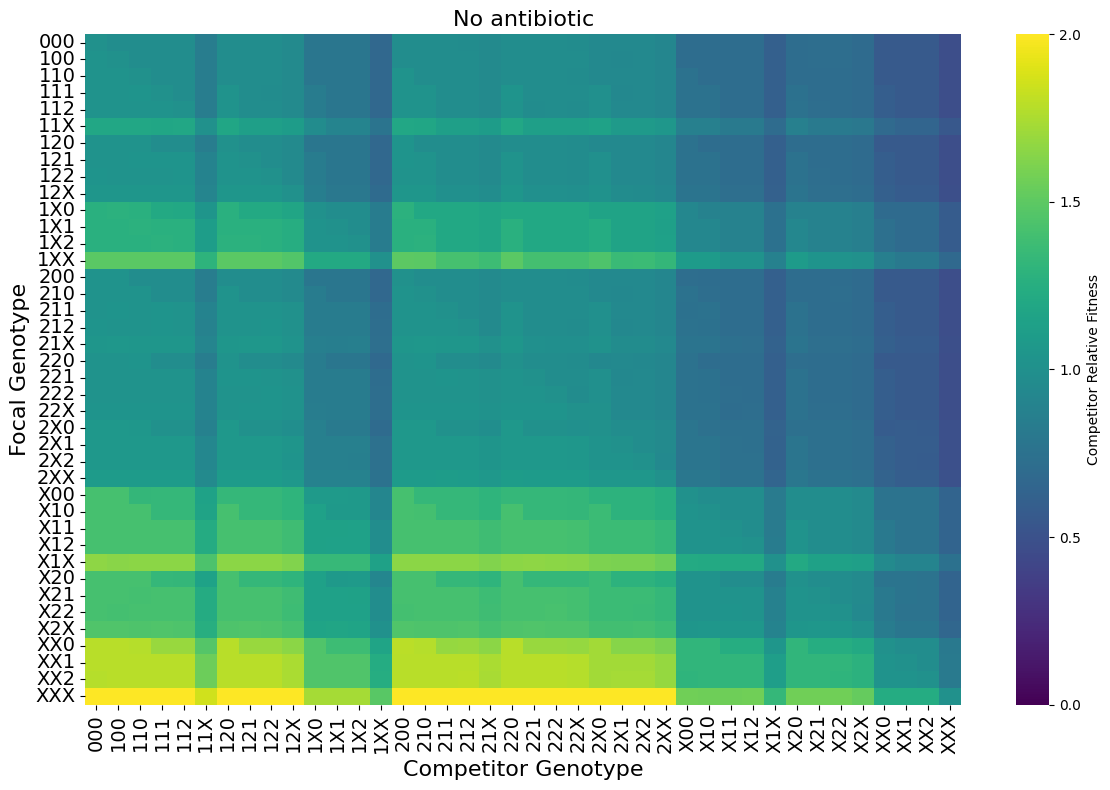

In [128]:


def plot_relative_fitness_heatmap(relative_fitness_matrix, labels_genotypes, title="Relative Fitness Heatmap", outPath=''):
    """
    Plots a heatmap of the relative fitness matrix with a colorbar centered on 1 and annotations.

    Parameters:
        relative_fitness_matrix (ndarray): Matrix containing relative fitness values.
        labels_genotypes (list): List of genotype labels corresponding to the matrix rows/columns.
        title (str): Title for the heatmap.

    Returns:
        None: Displays the heatmap.
    """
    # Set vmin and vmax such that 1 corresponds to the center of the colormap
    vmin = np.min(relative_fitness_matrix)
    vmax = np.max(relative_fitness_matrix)

    # Ensure the colormap is symmetric around 1
    max_abs = max(abs(vmin - 1), abs(vmax - 1))
    vmin = 1 - max_abs
    vmax = 1 + max_abs

    print(f"Colorbar limits: vmin={vmin:.2f}, vmax={vmax:.2f}")

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(
        relative_fitness_matrix,
        annot=False,
        fmt=".2f",
        cmap="viridis",
        xticklabels=labels_genotypes,
        yticklabels=labels_genotypes,
        cbar_kws={"label": "Competitor Relative Fitness"},
        vmin=vmin,
        vmax=vmax
    )

    # Annotate the colorbar to use ticks rounded to tenths
    colorbar = ax.collections[0].colorbar
    colorbar_ticks = np.linspace(vmin, vmax, num=5)  # Create 5 evenly spaced ticks
    colorbar_ticks = np.round(colorbar_ticks, 1)  # Round to the nearest tenths
    colorbar.set_ticks(colorbar_ticks)
    colorbar.set_ticklabels([f"{tick:.1f}" for tick in colorbar_ticks])
    colorbar.ax.yaxis.set_major_locator(ticker.FixedLocator(colorbar_ticks))

    # Add labels and formatting
    plt.xlabel("Competitor Genotype", fontsize=16)
    plt.ylabel("Focal Genotype", fontsize=16)
    plt.xticks(rotation=90, fontsize=14)
    plt.yticks(rotation=0, fontsize=14)
    plt.title(title, fontsize=16)
    plt.tight_layout()



    # Save or show plot
    if outPath:
        filename = f"{outPath}_fitnessMatrix.pdf"
        plt.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0.2)
        print(f"Exporting {filename}")
        plt.show()
        plt.close()
    else:
        plt.show()


# Drug-free
outPath='%s_A0'%(file_name_figures)
plot_relative_fitness_heatmap(
    relative_fitness_matrix=relative_fitness_matrix_nodrug,
    labels_genotypes=accessible_genotypes,
    title="No antibiotic",
    outPath=outPath
)


In [129]:
def get_strain_with_highest_density(dose_response_df, antibiotic_concentration):
    """
    Returns the label of the strain with the highest density at a given antibiotic concentration.

    Parameters:
        dose_response_df (pd.DataFrame): DataFrame containing dose-response results with columns
                                         'Antibiotic_Concentration', 'Strain_ID', and 'Final_Density'.
        antibiotic_concentration (float): The antibiotic concentration to query.

    Returns:
        str: The label of the strain with the highest density at the given antibiotic concentration.
    """
    # Filter the DataFrame for the given antibiotic concentration
    filtered_df = dose_response_df[dose_response_df['Antibiotic_Concentration'] == antibiotic_concentration]

    if filtered_df.empty:
        raise ValueError(f"No data found for antibiotic concentration: {antibiotic_concentration}")

    # Find the row with the maximum density
    max_density_row = filtered_df.loc[filtered_df['Final_Density'].idxmax()]

    # Return the strain label
    return max_density_row['Strain_ID']


highest_density_nodrug = get_strain_with_highest_density(dose_response_accessible_df, 0)
print(f"Strain with the highest density at drug={0}: {highest_density_nodrug}")


Strain with the highest density at drug=0: 000


Edge 12X -> 120: Fitness = 1.05
Edge 12X -> 1X0: Fitness = 0.85
Edge 12X -> 2X0: Fitness = 1.02
Edge 12X -> 21X: Fitness = 0.97
Edge 12X -> X12: Fitness = 0.73
Edge 120 -> 100: Fitness = 1.03
Edge 120 -> 200: Fitness = 1.03
Edge 120 -> 210: Fitness = 0.97
Edge 120 -> 112: Fitness = 0.97
Edge 120 -> 212: Fitness = 0.97
Edge 1X0 -> 100: Fitness = 1.28
Edge 1X0 -> X00: Fitness = 0.93
Edge 1X0 -> X10: Fitness = 0.88
Edge 1X0 -> 11X: Fitness = 1.04
Edge 1X0 -> X1X: Fitness = 0.75
Edge 2X0 -> 200: Fitness = 1.06
Edge 2X0 -> X00: Fitness = 0.78
Edge 2X0 -> X20: Fitness = 0.73
Edge 2X0 -> 22X: Fitness = 1.00
Edge 2X0 -> X2X: Fitness = 0.72
Edge 21X -> 1X0: Fitness = 0.85
Edge 21X -> 210: Fitness = 1.06
Edge 21X -> 2X0: Fitness = 1.02
Edge 21X -> 12X: Fitness = 1.03
Edge 21X -> X21: Fitness = 0.72
Edge X12 -> 120: Fitness = 1.41
Edge X12 -> X10: Fitness = 1.03
Edge X12 -> X20: Fitness = 1.02
Edge X12 -> 1X2: Fitness = 1.14
Edge X12 -> 2X1: Fitness = 1.36
Edge 100 -> 000: Fitness = 1.03
Edge 200

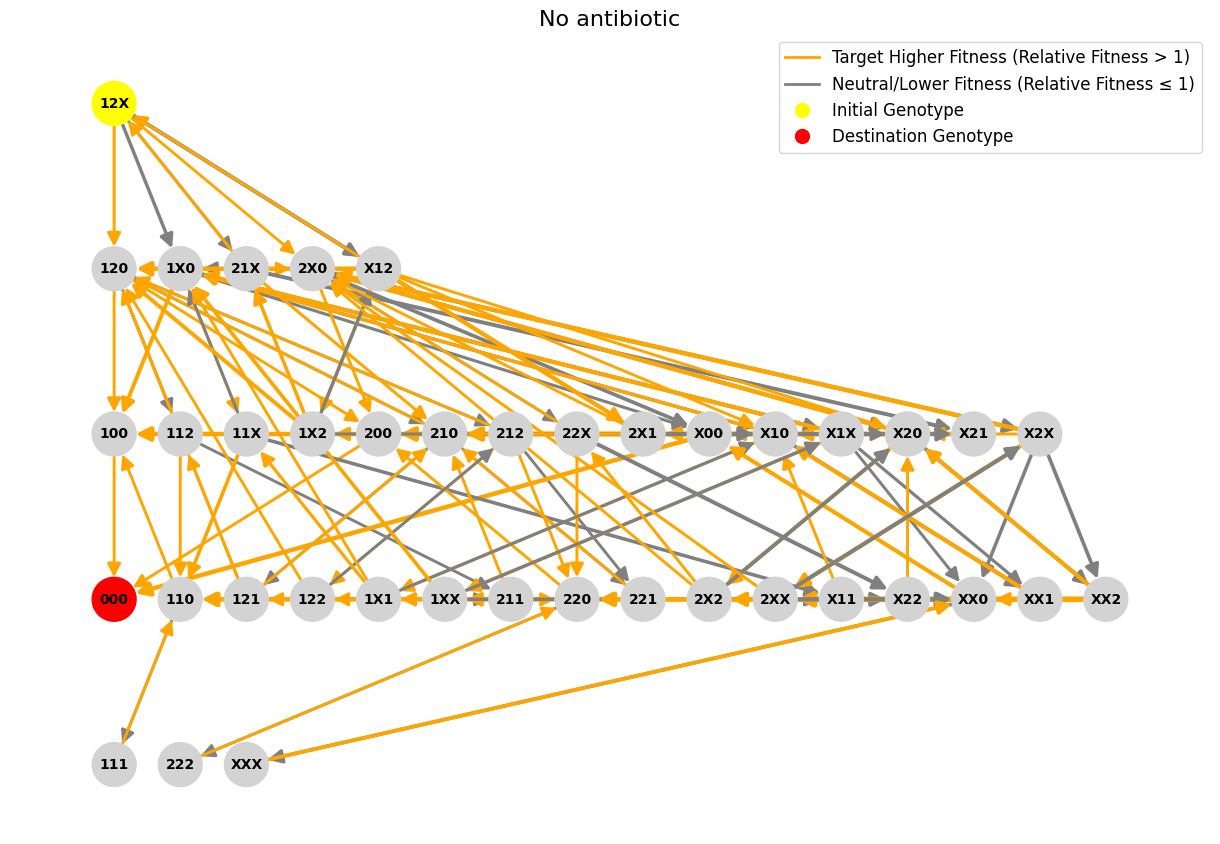

In [130]:
def visualize_accessibility_tree_with_fitness(
    initial_genotype_label, destination_genotype_label, labels_genotypes, M,
    relative_fitness_matrix, accessible_genotypes, title='', outPath=''
):
    """
    Visualizes the accessibility tree using NetworkX and Matplotlib with nodes organized in layers
    based on their distance from the initial genotype. Colors edges red if the target genotype has
    higher relative fitness than the source genotype, and gray otherwise. The destination genotype
    is highlighted in a different color.

    Parameters:
        initial_genotype_label (str): The initial genotype label.
        destination_genotype_label (str): The destination genotype label.
        labels_genotypes (list): List of genotype labels corresponding to the indices.
        M_exc (ndarray): Excitation matrix.
        M_int (ndarray): Interaction matrix.
        relative_fitness_matrix (ndarray): Matrix of relative fitness values between accessible genotypes.
        accessible_genotypes (list): List of accessible genotype labels corresponding to the reduced matrix.
        title (str): Title for the plot.

    Returns:
        None: Displays the tree graph.
    """
    # Find the index corresponding to the initial_genotype_label
    if initial_genotype_label not in labels_genotypes:
        raise ValueError(f"Initial genotype label '{initial_genotype_label}' not found in labels_genotypes.")
    initial_genotype_index = labels_genotypes.index(initial_genotype_label)

    # Construct the accessibility tree
    tree = construct_accessibility_tree(initial_genotype_index, M)

    # Create a directed graph
    G = nx.DiGraph()
    edge_colors = []  # To store edge colors based on relative fitness
    edge_weights = []  # To store edge widths

    # Map original genotype indices to accessible genotype indices
    accessible_indices_map = {label: idx for idx, label in enumerate(accessible_genotypes)}

    # Add nodes and edges to the graph, tagging edges with fitness-based colors
    for parent, children in tree.items():
        parent_label = labels_genotypes[parent]  # Convert index to label
        if parent_label not in accessible_indices_map:
            continue  # Skip nodes not in the accessible genotypes

        for child in children:
            if parent != child:  # Skip self-loops
                child_label = labels_genotypes[child]  # Convert index to label
                if child_label not in accessible_indices_map:
                    continue  # Skip nodes not in the accessible genotypes

                G.add_edge(parent_label, child_label)

                # Get the relative fitness value of the target genotype (child) relative to the source genotype (parent)
                fitness = relative_fitness_matrix[accessible_indices_map[parent_label], accessible_indices_map[child_label]]
                fitness = fitness if np.isfinite(fitness) else 1

                # Debugging fitness values
                print(f"Edge {parent_label} -> {child_label}: Fitness = {fitness:.2f}")

                # Use fitness to determine edge color and width
                if fitness > 1:
                    edge_colors.append('orange')  # Highlight paths with higher fitness at the target
                else:
                    edge_colors.append('gray')  # Neutral/low fitness paths
                edge_weights.append(2 + 3 * abs(fitness - 1))  # Scale edge width with deviation from 1

    # Compute the distance (number of transitions) from the initial genotype
    distances = {initial_genotype_label: 0}
    queue = [(initial_genotype_label, 0)]
    while queue:
        current, dist = queue.pop(0)
        for neighbor in G.successors(current):
            if neighbor not in distances:
                distances[neighbor] = dist + 1
                queue.append((neighbor, dist + 1))

    # Organize nodes into layers based on their distance
    layers = defaultdict(list)
    for node, distance in distances.items():
        layers[distance].append(node)

    # Sort nodes within each layer alphabetically
    for layer in layers.values():
        layer.sort()

    # Create a layered layout
    pos = {}
    y_spacing = 3  # Vertical space between layers
    x_spacing = 2  # Horizontal space between nodes
    for y, (distance, nodes) in enumerate(sorted(layers.items())):
        for x, node in enumerate(nodes):
            pos[node] = (x * x_spacing, -y * y_spacing)

    # Draw the graph
    plt.figure(figsize=(12, 8))
    node_colors = [
        'yellow' if node == initial_genotype_label else
        'red' if node == destination_genotype_label else
        'lightgrey' for node in G.nodes()
    ]
    nx.draw(
        G, pos, with_labels=True, node_size=1000, node_color=node_colors,
        font_size=10, font_weight="bold", arrowsize=20, edge_color=edge_colors, width=edge_weights
    )

    # Add a legend for edge colors
    legend_elements = [
        plt.Line2D([0], [0], color='orange', lw=2, label='Target Higher Fitness (Relative Fitness > 1)'),
        plt.Line2D([0], [0], color='gray', lw=2, label='Neutral/Lower Fitness (Relative Fitness ≤ 1)'),
        plt.Line2D([0], [0], color='yellow', marker='o', markersize=10, label='Initial Genotype', lw=0),
        plt.Line2D([0], [0], color='red', marker='o', markersize=10, label='Destination Genotype', lw=0)
    ]
    plt.legend(handles=legend_elements, loc='best', fontsize=12)
    plt.title(title, fontsize=16)




    # Save or show plot
    if outPath:
        filename = f"{outPath}_fitnessNetwork.pdf"
        plt.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0.2)
        print(f"Exporting {filename}")
        plt.show()
        plt.close()
    else:
        plt.show()




outPath='%s_A0'%(file_name_figures)
destination_label_nodrug = highest_density_nodrug
visualize_accessibility_tree_with_fitness(
    initial_genotype_label=initial_genotype_label,
    destination_genotype_label=destination_label_nodrug,
    labels_genotypes=labels_genotypes,
    M=M,
    relative_fitness_matrix=relative_fitness_matrix_nodrug,
    accessible_genotypes=accessible_genotypes,
    title="No antibiotic",
    outPath=outPath
)


In [131]:
def find_all_paths(tree, start, destination, path=None, all_paths=None):
    """
    Finds all possible paths between the start node and the destination node in the tree.

    Parameters:
        tree (dict): Accessibility tree where keys are genotypes and values are lists of accessible genotypes.
        start (str): Starting node (genotype label).
        destination (str): Destination node (genotype label).
        path (list): Current path being explored (used internally for recursion).
        all_paths (list): List of all paths found (used internally for recursion).

    Returns:
        all_paths (list of lists): List of all possible paths from start to destination.
    """
    if path is None:
        path = []
    if all_paths is None:
        all_paths = []

    # Add the current node to the path
    path = path + [start]

    # If we reach the destination, add the path to the results
    if start == destination:
        all_paths.append(path)
        return all_paths

    # If the start node is not in the tree, there are no further paths
    if start not in tree:
        return all_paths

    # Recur for each neighbor of the current node
    for neighbor in tree[start]:
        if neighbor not in path:  # Avoid cycles
            find_all_paths(tree, neighbor, destination, path, all_paths)

    return all_paths


# No drug
destination_label_nodrug = highest_density_nodrug
all_paths_nodrug = find_all_paths(accessibility_tree_labels, initial_genotype_label, destination_label_nodrug)
print(f"All paths from {initial_genotype_label} to {destination_label_nodrug}:")
for path in all_paths_nodrug:
    print(" -> ".join(path))


All paths from 12X to 000:
12X -> 120 -> 100 -> 000
12X -> 120 -> 200 -> 000
12X -> 120 -> 210 -> 100 -> 000
12X -> 120 -> 210 -> 200 -> 000
12X -> 120 -> 210 -> 121 -> 110 -> 100 -> 000
12X -> 120 -> 210 -> 121 -> 112 -> 110 -> 100 -> 000
12X -> 120 -> 210 -> 121 -> 112 -> 211 -> 110 -> 100 -> 000
12X -> 120 -> 210 -> 121 -> 211 -> 110 -> 100 -> 000
12X -> 120 -> 210 -> 221 -> 220 -> 200 -> 000
12X -> 120 -> 210 -> 221 -> 122 -> 220 -> 200 -> 000
12X -> 120 -> 210 -> 221 -> 122 -> 212 -> 220 -> 200 -> 000
12X -> 120 -> 112 -> 110 -> 100 -> 000
12X -> 120 -> 112 -> 211 -> 110 -> 100 -> 000
12X -> 120 -> 112 -> 211 -> 210 -> 100 -> 000
12X -> 120 -> 112 -> 211 -> 210 -> 200 -> 000
12X -> 120 -> 112 -> 211 -> 210 -> 121 -> 110 -> 100 -> 000
12X -> 120 -> 112 -> 211 -> 210 -> 221 -> 220 -> 200 -> 000
12X -> 120 -> 112 -> 211 -> 210 -> 221 -> 122 -> 220 -> 200 -> 000
12X -> 120 -> 112 -> 211 -> 210 -> 221 -> 122 -> 212 -> 220 -> 200 -> 000
12X -> 120 -> 112 -> 211 -> 121 -> 110 -> 100 -> 0

In [132]:
def plot_relative_fitness_for_paths(
    initial_genotype_label, destination_label, accessibility_tree, labels_genotypes,
    accessible_genotypes, relative_fitness_matrix
):
    """
    Plots vertically stacked scatter plots of relative fitness values for consecutive genotypes
    along all paths from the initial genotype to the destination genotype.

    Parameters:
        initial_genotype_label (str): The initial genotype label.
        destination_label (str): The destination genotype label.
        accessibility_tree (dict): Accessibility tree where keys are genotypes and values are accessible genotypes.
        labels_genotypes (list): List of all genotype labels.
        accessible_genotypes (list): List of accessible genotype labels corresponding to the matrix rows/columns.
        relative_fitness_matrix (np.ndarray): Relative fitness matrix for accessible genotypes.
    """
    # Find all paths from initial to destination genotype
    all_paths = find_all_paths(accessibility_tree, initial_genotype_label, destination_label)

    if not all_paths:
        print(f"No paths found from {initial_genotype_label} to {destination_label}.")
        return

    num_paths = len(all_paths)

    # Create a figure for stacked subplots
    fig, axes = plt.subplots(num_paths, 1, figsize=(6, 3 * num_paths), sharex=False, squeeze=False)
    axes = axes.flatten()  # Flatten to simplify iteration

    # Iterate over each path
    for idx, path in enumerate(all_paths):
        ax = axes[idx]

        # Get indices for genotypes in the path
        path_indices = [accessible_genotypes.index(genotype) for genotype in path]

        # Calculate fitness values relative to the previous genotype in the path
        fitness_values = [
            relative_fitness_matrix[path_indices[i], path_indices[i + 1]]
            for i in range(len(path_indices) - 1)
        ]

        # Prepare x-axis labels and colors for scatter points
        x_labels = [initial_genotype_label] + path[1:]  # Include the initial genotype as the first label
        fitness_values = [1] + fitness_values  # Include the fitness of the initial genotype (relative to itself)
        colors = ['black'] + ['red' if fv > 1 else 'gray' for fv in fitness_values[1:]]  # Color for the origin

        # Scatter plot with a dotted line connecting the points
        x_positions = range(len(x_labels))
        ax.plot(x_positions, fitness_values, linestyle=':', color='black', alpha=0.7)  # Dotted line
        ax.scatter(x_positions, fitness_values, color=colors, s=50, edgecolor='black')  # Points

        # Add labels and formatting
        ax.axhline(y=1, color='black', linestyle='--', linewidth=1)  # Neutral fitness line
        ax.set_ylabel(f'Relative Fitness', fontsize=12)
        ax.set_title(f" {' -> '.join(path)}", fontsize=12)
        ax.set_xticks(x_positions)
        ax.set_xticklabels(x_labels, rotation=90, fontsize=10)
        max_value=np.max(fitness_values)
        ax.set_ylim([0.5, 1.1*max_value if max_value > 1.5 else 1.5])


    # Add a common xlabel for the entire figure
    #fig.text(0.5, 0.04, 'Genotypes', ha='center', fontsize=14)
    plt.tight_layout()
    plt.show()


# Example usage
#plot_relative_fitness_for_paths(
#    initial_genotype_label=initial_genotype_label,
#    destination_label=destination_label_nodrug,
#    accessibility_tree=accessibility_tree_labels,
#    labels_genotypes=labels_genotypes,
#    accessible_genotypes=accessible_genotypes,
#    relative_fitness_matrix=relative_fitness_matrix_nodrug
#)


In [133]:
def find_accessible_paths(
    initial_genotype_label, destination_label, accessibility_tree, labels_genotypes,
    accessible_genotypes, relative_fitness_matrix
):
    """
    Identifies accessible paths where the relative fitness between consecutive genotypes is always >1.

    Parameters:
        initial_genotype_label (str): The initial genotype label.
        destination_label (str): The destination genotype label.
        accessibility_tree (dict): Accessibility tree where keys are genotypes and values are accessible genotypes.
        labels_genotypes (list): List of all genotype labels.
        accessible_genotypes (list): List of accessible genotype labels corresponding to the matrix rows/columns.
        relative_fitness_matrix (np.ndarray): Relative fitness matrix for accessible genotypes.

    Returns:
        list: A list of accessible paths where all transitions have relative fitness >1.
    """
    # Find all paths from initial to destination genotype
    print(f"Finding all paths from {initial_genotype_label} to {destination_label}...")
    all_paths = find_all_paths(accessibility_tree, initial_genotype_label, destination_label)

    if not all_paths:
        print(f"No paths found from {initial_genotype_label} to {destination_label}.")
        return []

    print(f"Total paths found: {len(all_paths)}")
    accessible_paths = []

    # Iterate over all paths to identify accessible ones
    for path_index, path in enumerate(all_paths):
        print(f"\nChecking path {path_index + 1}/{len(all_paths)}: {' -> '.join(path)}")

        try:
            path_indices = [accessible_genotypes.index(genotype) for genotype in path]
        except ValueError as e:
            print(f"Error: Genotype in path not found in accessible_genotypes. Details: {e}")
            continue


        # Check if all transitions in the path have relative fitness > 1
        is_accessible = True
        for i in range(len(path_indices) - 1):
            src = path_indices[i]
            tgt = path_indices[i + 1]
            fitness = relative_fitness_matrix[src, tgt]
            print(f"Relative fitness from {path[i]} to {path[i + 1]}: {fitness:.2f}")
            if fitness < 1:
                print(f"Transition from {path[i]} to {path[i + 1]} is not accessible (fitness < 1).")
                is_accessible = False
                break

        if is_accessible:
            print(f"Path {path_index + 1} is accessible.")
            accessible_paths.append(path)
        else:
            print(f"Path {path_index + 1} is not accessible.")

    # Calculate the fraction of accessible paths
    fraction_accessible = 100 * len(accessible_paths) / len(all_paths) if all_paths else 0
    print(f"\nFraction of accessible paths: {fraction_accessible:.2f}% ({len(accessible_paths)}/{len(all_paths)})")

    return accessible_paths

accessible_paths_nodrug = find_accessible_paths(
    initial_genotype_label=initial_genotype_label,
    destination_label=destination_label_nodrug,
    accessibility_tree=accessibility_tree_labels,
    labels_genotypes=labels_genotypes,
    accessible_genotypes=accessible_genotypes,
    relative_fitness_matrix=relative_fitness_matrix_nodrug
)

# Print the accessible paths
print("Accessible Paths:")
for path in accessible_paths_nodrug:
    print(" -> ".join(path))


Streaming output truncated to the last 5000 lines.
Checking path 1066/2064: 12X -> X12 -> 1X2 -> 120 -> 212 -> 220 -> 200 -> 000
Relative fitness from 12X to X12: 0.73
Transition from 12X to X12 is not accessible (fitness < 1).
Path 1066 is not accessible.

Checking path 1067/2064: 12X -> X12 -> 1X2 -> 120 -> 212 -> 122 -> 220 -> 200 -> 000
Relative fitness from 12X to X12: 0.73
Transition from 12X to X12 is not accessible (fitness < 1).
Path 1067 is not accessible.

Checking path 1068/2064: 12X -> X12 -> 1X2 -> 120 -> 212 -> 221 -> 210 -> 100 -> 000
Relative fitness from 12X to X12: 0.73
Transition from 12X to X12 is not accessible (fitness < 1).
Path 1068 is not accessible.

Checking path 1069/2064: 12X -> X12 -> 1X2 -> 120 -> 212 -> 221 -> 210 -> 200 -> 000
Relative fitness from 12X to X12: 0.73
Transition from 12X to X12 is not accessible (fitness < 1).
Path 1069 is not accessible.

Checking path 1070/2064: 12X -> X12 -> 1X2 -> 120 -> 212 -> 221 -> 210 -> 121 -> 110 -> 100 -> 000
R

Exporting /content/drive/MyDrive/SYNC_Projects/MI/figures/X_aacA37_aacA45/X_aacA37_aacA45_A0_accessibleNetwork.pdf


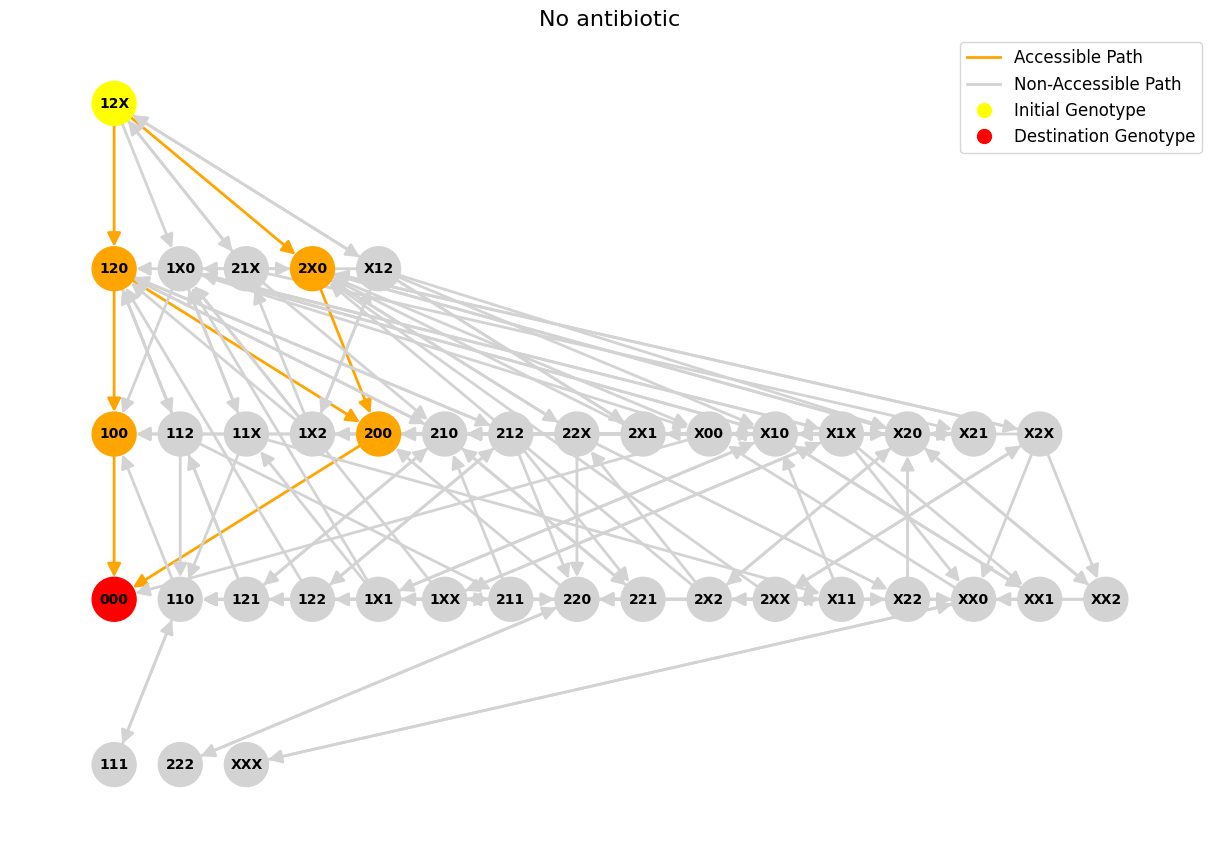

In [134]:
def visualize_accessibility_tree_landscape(
    initial_genotype_label, destination_genotype_label, labels_genotypes, M,
    relative_fitness_matrix, accessible_genotypes, accessible_paths, title='', outPath=''
):
    """
    Visualizes the accessibility tree using NetworkX and Matplotlib with nodes organized in layers.
    Nodes and edges on accessible paths (provided as input) are colored red, and others are gray.
    The destination genotype is highlighted.

    Parameters:
        initial_genotype_label (str): The initial genotype label.
        destination_genotype_label (str): The destination genotype label.
        labels_genotypes (list): List of genotype labels corresponding to the indices.
        M_exc (ndarray): Excitation matrix.
        M_int (ndarray): Interaction matrix.
        relative_fitness_matrix (ndarray): Matrix of relative fitness values between accessible genotypes.
        accessible_genotypes (list): List of accessible genotype labels corresponding to the reduced matrix.
        accessible_paths (list of lists): List of accessible paths (each path is a list of genotypes).
        title (str): Title for the plot.

    Returns:
        None: Displays the tree graph.
    """
    # Find the index corresponding to the initial_genotype_label
    if initial_genotype_label not in labels_genotypes:
        raise ValueError(f"Initial genotype label '{initial_genotype_label}' not found in labels_genotypes.")
    initial_genotype_index = labels_genotypes.index(initial_genotype_label)

    # Construct the accessibility tree
    tree = construct_accessibility_tree(initial_genotype_index, M)

    # Collect nodes and edges from accessible paths
    accessible_nodes = set()
    accessible_edges = set()
    for path in accessible_paths:
        accessible_nodes.update(path)
        for i in range(len(path) - 1):
            accessible_edges.add((path[i], path[i + 1]))

    # Create a directed graph
    G = nx.DiGraph()
    edge_colors = []  # To store edge colors
    edge_weights = []  # To store edge widths

    # Map original genotype indices to accessible genotype indices
    accessible_indices_map = {label: idx for idx, label in enumerate(accessible_genotypes)}

    # Add nodes and edges to the graph
    for parent, children in tree.items():
        parent_label = labels_genotypes[parent]  # Convert index to label
        if parent_label not in accessible_indices_map:
            continue  # Skip nodes not in the accessible genotypes

        for child in children:
            if parent != child:  # Skip self-loops
                child_label = labels_genotypes[child]  # Convert index to label
                if child_label not in accessible_indices_map:
                    continue  # Skip nodes not in the accessible genotypes

                G.add_edge(parent_label, child_label)

                # Color edges based on whether they are in an accessible path
                if (parent_label, child_label) in accessible_edges:
                    edge_colors.append('orange')  # Highlight edges in accessible paths
                else:
                    edge_colors.append('lightgray')  # Non-accessible edges
                edge_weights.append(2)

    # Organize nodes into layers based on their distance
    distances = {initial_genotype_label: 0}
    queue = [(initial_genotype_label, 0)]
    while queue:
        current, dist = queue.pop(0)
        for neighbor in G.successors(current):
            if neighbor not in distances:
                distances[neighbor] = dist + 1
                queue.append((neighbor, dist + 1))

    # Organize nodes into layers
    layers = defaultdict(list)
    for node, distance in distances.items():
        layers[distance].append(node)

    # Sort nodes within each layer alphabetically
    for layer in layers.values():
        layer.sort()

    # Create a layered layout
    pos = {}
    y_spacing = 3  # Vertical space between layers
    x_spacing = 2  # Horizontal space between nodes
    for y, (distance, nodes) in enumerate(sorted(layers.items())):
        for x, node in enumerate(nodes):
            pos[node] = (x * x_spacing, -y * y_spacing)

    # Draw the graph
    plt.figure(figsize=(12, 8))
    node_colors = [
        'yellow' if node == initial_genotype_label else
        'red' if node == destination_genotype_label else
        'orange' if node in accessible_nodes else
        'lightgray'
        for node in G.nodes()
    ]
    nx.draw(
        G, pos, with_labels=True, node_size=1000, node_color=node_colors,
        font_size=10, font_weight="bold", arrowsize=20, edge_color=edge_colors, width=edge_weights
    )

    # Add a legend for edge and node colors
    legend_elements = [
        plt.Line2D([0], [0], color='orange', lw=2, label='Accessible Path'),
        plt.Line2D([0], [0], color='lightgray', lw=2, label='Non-Accessible Path'),
        plt.Line2D([0], [0], color='yellow', marker='o', markersize=10, label='Initial Genotype', lw=0),
        plt.Line2D([0], [0], color='red', marker='o', markersize=10, label='Destination Genotype', lw=0)
    ]
    plt.legend(handles=legend_elements, loc='best', fontsize=12)
    plt.title(title, fontsize=16)

    # Save or show plot
    if outPath:
        filename = f"{outPath}_accessibleNetwork.pdf"
        plt.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0.2)
        print(f"Exporting {filename}")
        plt.show()
        plt.close()
    else:
        plt.show()




outPath='%s_A0'%(file_name_figures)
visualize_accessibility_tree_landscape(
    initial_genotype_label=initial_genotype_label,
    destination_genotype_label=destination_label_nodrug,
    labels_genotypes=labels_genotypes,
    M=M,
    relative_fitness_matrix=relative_fitness_matrix_nodrug,
    accessible_genotypes=accessible_genotypes,
    accessible_paths=accessible_paths_nodrug,
    title="No antibiotic",
    outPath=outPath
)


In [135]:

def compute_basin_of_attraction(initial_genotype_label, destination_label, accessibility_tree, labels_genotypes,
    accessible_genotypes, relative_fitness_matrix):
    """
    Identifies the basin of attraction of the highest fitness genotype by finding all genotypes
    that have accessible paths leading to the highest fitness genotype.
    """

    # Identify the basin of attraction
    basin_of_attraction = []

    for genotype_label in accessibility_tree_labels.keys():
        # Skip the highest density label itself
        if genotype_label == destination_label:
            continue

        # Check if there are accessible paths
        accessible_paths = find_accessible_paths(
            initial_genotype_label=genotype_label,
            destination_label=destination_label,
            accessibility_tree=accessibility_tree_labels,
            labels_genotypes=labels_genotypes,
            accessible_genotypes=accessible_genotypes,
            relative_fitness_matrix=relative_fitness_matrix
        )

        if accessible_paths:
            basin_of_attraction.append(genotype_label)

    print(f"Basin of attraction size: {len(basin_of_attraction)}")

    return basin_of_attraction


Streaming output truncated to the last 5000 lines.

Checking path 20/91: 122 -> 120 -> 212 -> 210 -> 100 -> 000
Relative fitness from 122 to 120: 1.03
Relative fitness from 120 to 212: 0.97
Transition from 120 to 212 is not accessible (fitness < 1).
Path 20 is not accessible.

Checking path 21/91: 122 -> 120 -> 212 -> 210 -> 200 -> 000
Relative fitness from 122 to 120: 1.03
Relative fitness from 120 to 212: 0.97
Transition from 120 to 212 is not accessible (fitness < 1).
Path 21 is not accessible.

Checking path 22/91: 122 -> 120 -> 212 -> 210 -> 121 -> 110 -> 100 -> 000
Relative fitness from 122 to 120: 1.03
Relative fitness from 120 to 212: 0.97
Transition from 120 to 212 is not accessible (fitness < 1).
Path 22 is not accessible.

Checking path 23/91: 122 -> 120 -> 212 -> 210 -> 121 -> 112 -> 110 -> 100 -> 000
Relative fitness from 122 to 120: 1.03
Relative fitness from 120 to 212: 0.97
Transition from 120 to 212 is not accessible (fitness < 1).
Path 23 is not accessible.

Checking 

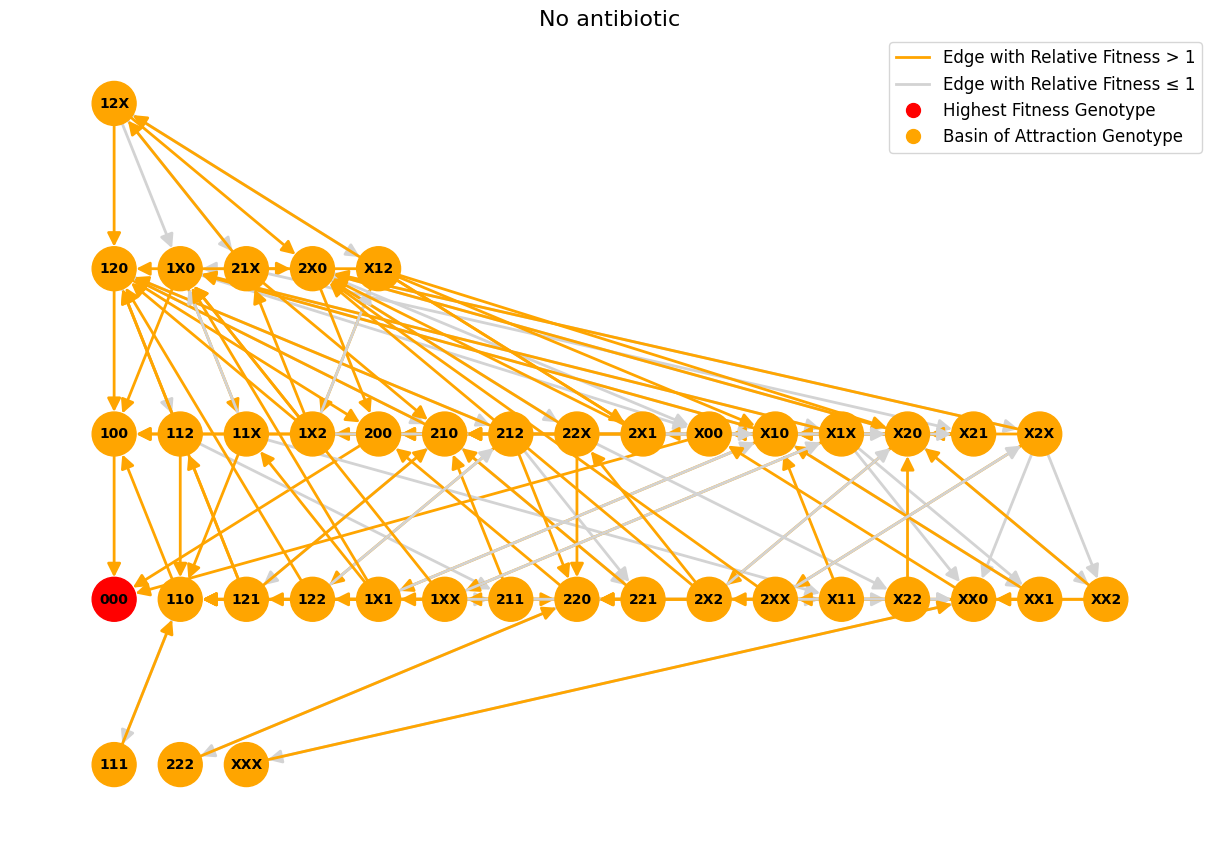

In [136]:
def visualize_basin_of_attraction(
    initial_genotype_label, destination_genotype_label, labels_genotypes, M,
    relative_fitness_matrix, accessible_genotypes, basin_of_attraction, title='', outPath=''
):
    """
    Visualizes the accessibility tree using NetworkX and Matplotlib with nodes organized in layers.
    Basin of attraction nodes are colored orange, and paths within the basin are orange.
    All other nodes are gray, except for the destination genotype, which is red.

    Parameters:
        initial_genotype_label (str): The initial genotype label.
        destination_genotype_label (str): The destination genotype label.
        labels_genotypes (list): List of genotype labels corresponding to the indices.
        M_exc (ndarray): Excitation matrix.
        M_int (ndarray): Interaction matrix.
        relative_fitness_matrix (ndarray): Matrix of relative fitness values between accessible genotypes.
        accessible_genotypes (list): List of accessible genotype labels corresponding to the reduced matrix.
        basin_of_attraction (list): List of genotypes in the basin of attraction.
        title (str): Title for the plot.
        outPath (str): Output path to save the plot.

    Returns:
        None: Displays or saves the graph.
    """
    # Find the index corresponding to the initial_genotype_label
    if initial_genotype_label not in labels_genotypes:
        raise ValueError(f"Initial genotype label '{initial_genotype_label}' not found in labels_genotypes.")
    initial_genotype_index = labels_genotypes.index(initial_genotype_label)

    # Construct the accessibility tree from the initial genotype
    tree = construct_accessibility_tree(initial_genotype_index, M)

    # Create a directed graph
    G = nx.DiGraph()
    edge_colors = []  # To store edge colors
    edge_weights = []  # To store edge widths

    # Map original genotype indices to accessible genotype indices
    accessible_indices_map = {label: idx for idx, label in enumerate(accessible_genotypes)}

    # Add nodes and edges to the graph
    for parent, children in tree.items():
        parent_label = labels_genotypes[parent]  # Convert index to label
        if parent_label not in accessible_indices_map:
            continue  # Skip nodes not in the accessible genotypes

        for child in children:
            if parent != child:  # Skip self-loops
                child_label = labels_genotypes[child]  # Convert index to label
                if child_label not in accessible_indices_map:
                    continue  # Skip nodes not in the accessible genotypes

                G.add_edge(parent_label, child_label)

                # Determine the relative fitness of the edge
                parent_idx = accessible_indices_map[parent_label]
                child_idx = accessible_indices_map[child_label]
                relative_fitness = relative_fitness_matrix[parent_idx, child_idx]
                relative_fitness = relative_fitness if np.isfinite(relative_fitness) else 1.0

                # Color the edge orange only if relative fitness > 1
                if relative_fitness > 1:
                    edge_colors.append('orange')
                else:
                    edge_colors.append('lightgray')  # Non-basin edges
                edge_weights.append(2)

    # Compute distances from the initial genotype
    distances = {initial_genotype_label: 0}
    queue = [(initial_genotype_label, 0)]
    while queue:
        current, dist = queue.pop(0)
        for neighbor in G.successors(current):
            if neighbor not in distances:
                distances[neighbor] = dist + 1
                queue.append((neighbor, dist + 1))

    # Organize nodes into layers based on their distance
    layers = defaultdict(list)
    for node, distance in distances.items():
        layers[distance].append(node)

    # Sort nodes within each layer alphabetically
    for layer in layers.values():
        layer.sort()

    # Create a layered layout
    pos = {}
    y_spacing = 3  # Vertical space between layers
    x_spacing = 2  # Horizontal space between nodes
    for y, (distance, nodes) in enumerate(sorted(layers.items())):
        for x, node in enumerate(nodes):
            pos[node] = (x * x_spacing, -y * y_spacing)

    # Draw the graph
    plt.figure(figsize=(12, 8))
    node_colors = [
        'red' if node == destination_genotype_label else
        'orange' if node in basin_of_attraction else
        'lightgray'
        for node in G.nodes()
    ]
    nx.draw(
        G, pos, with_labels=True, node_size=1000, node_color=node_colors,
        font_size=10, font_weight="bold", arrowsize=20, edge_color=edge_colors, width=edge_weights
    )

    # Add a legend for edge and node colors
    legend_elements = [
        plt.Line2D([0], [0], color='orange', lw=2, label='Edge with Relative Fitness > 1'),
        plt.Line2D([0], [0], color='lightgray', lw=2, label='Edge with Relative Fitness ≤ 1'),
        plt.Line2D([0], [0], color='red', marker='o', markersize=10, label='Highest Fitness Genotype', lw=0),
        plt.Line2D([0], [0], color='orange', marker='o', markersize=10, label='Basin of Attraction Genotype', lw=0)
    ]
    plt.legend(handles=legend_elements, loc='best', fontsize=12)
    plt.title(title, fontsize=16)

    # Save or show plot
    if outPath:
        filename = f"{outPath}_basinOfAttraction.pdf"
        plt.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0.2)
        print(f"Exporting {filename}")
        plt.show()
        plt.close()
    else:
        plt.show()





outPath='%s_A0'%(file_name_figures)

basin_of_attraction_nodrug = compute_basin_of_attraction(
    initial_genotype_label=initial_genotype_label,
    destination_label=destination_label_nodrug,
    accessibility_tree=accessibility_tree_labels,
    labels_genotypes=labels_genotypes,
    accessible_genotypes=accessible_genotypes,
    relative_fitness_matrix=relative_fitness_matrix_nodrug
)


visualize_basin_of_attraction(
    initial_genotype_label=initial_genotype_label,
    destination_genotype_label=destination_label_nodrug,
    labels_genotypes=labels_genotypes,
    M=M,
    relative_fitness_matrix=relative_fitness_matrix_nodrug,
    accessible_genotypes=accessible_genotypes,
    basin_of_attraction=basin_of_attraction_nodrug,
    title="No antibiotic",
    outPath=outPath
)



## With drugs

000->110 (2.87e+06->2.86e+06) : 0.9968
000->100 (2.87e+06->2.86e+06) : 0.9968
000->111 (2.89e+06->2.86e+06) : 0.9918
000->112 (2.89e+06->2.86e+06) : 0.9918
000->11X (1.67e+05->2.15e+07) : 2.0000
000->120 (2.88e+06->2.86e+06) : 0.9933
000->121 (2.89e+06->2.86e+06) : 0.9911
000->122 (2.88e+06->2.87e+06) : 0.9938
000->12X (2.29e+06->7.67e+06) : 2.0000
000->1X0 (4.92e+04->1.95e+07) : 2.0000
000->1X1 (4.89e+04->1.95e+07) : 2.0000
000->1XX (1.36e+04->2.38e+07) : 2.0000
000->1X2 (4.89e+04->1.95e+07) : 2.0000
000->200 (2.88e+06->2.87e+06) : 0.9985
000->210 (2.86e+06->2.88e+06) : 1.0061
000->211 (2.88e+06->2.87e+06) : 0.9960
000->212 (2.88e+06->2.86e+06) : 0.9945
000->21X (2.30e+06->7.64e+06) : 2.0000000->220 (2.89e+06->2.85e+06) : 0.9883

000->221 (2.87e+06->2.86e+06) : 0.9978
000->222 (2.86e+06->2.88e+06) : 1.0041
000->22X (2.78e+06->3.45e+06) : 1.2408
000->2X0 (1.97e+06->1.07e+07) : 2.0000
000->2X1 (1.98e+06->1.07e+07) : 2.0000000->2X2 (1.97e+06->1.07e+07) : 2.0000

000->2XX (1.29e+06->1.78e

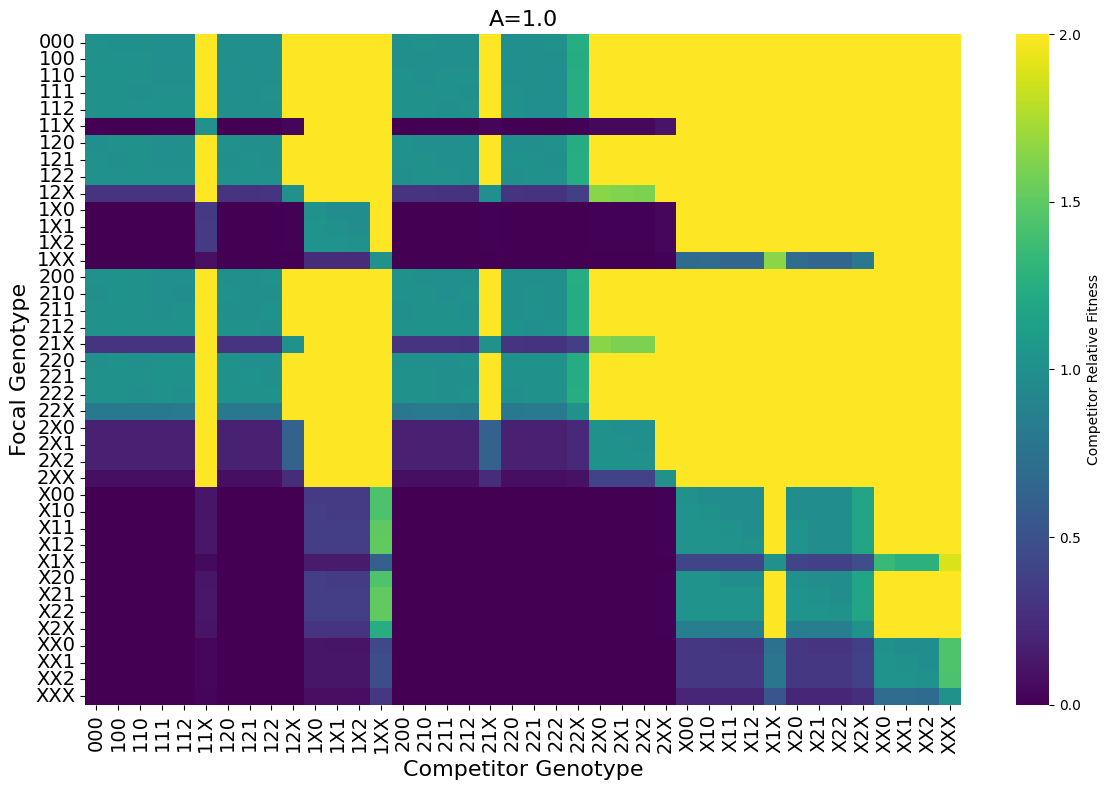

In [137]:



relative_fitness_matrix_drug, accessible_genotypes = compute_relative_fitness_matrix_for_accessible_parallel(
    M, strains=strains,
    labels_genotypes=labels_genotypes,
    num_days=1, #single day
    initial_resource=initial_resource,
    simulation_time=simulation_time,
    dilution_factor=dilution_factor,
    transition_rate=0, #No transition for competition experiments
    antibiotic_concentration=max_antibiotic_concentration,  # with drug
    accessibility_tree=accessibility_tree_labels,
    p_sos_min=p_sos_min, c_sos=c_sos, k_sos=k_sos, max_antibiotic_concentration=max_antibiotic_concentration

)

highest_density_drug = get_strain_with_highest_density(dose_response_accessible_df, max_antibiotic_concentration) # with drug
print(f"Strain with the highest density at drug={max_antibiotic_concentration}: {highest_density_drug}")


outPath='%s_Amax'%(file_name_figures)
destination_label_drug = highest_density_drug
plot_relative_fitness_heatmap(
    relative_fitness_matrix=relative_fitness_matrix_drug,
    labels_genotypes=accessible_genotypes,
    title="A=%s"%max_antibiotic_concentration,
    outPath=outPath
)

Edge 12X -> 120: Fitness = 0.30
Edge 12X -> 1X0: Fitness = 2.00
Edge 12X -> 2X0: Fitness = 1.65
Edge 12X -> 21X: Fitness = 0.99
Edge 12X -> X12: Fitness = 2.00
Edge 120 -> 100: Fitness = 1.00
Edge 120 -> 200: Fitness = 1.01
Edge 120 -> 210: Fitness = 0.99
Edge 120 -> 112: Fitness = 1.00
Edge 120 -> 212: Fitness = 0.99
Edge 1X0 -> 100: Fitness = 0.00
Edge 1X0 -> X00: Fitness = 2.00
Edge 1X0 -> X10: Fitness = 2.00
Edge 1X0 -> 11X: Fitness = 0.33
Edge 1X0 -> X1X: Fitness = 2.00
Edge 2X0 -> 200: Fitness = 0.18
Edge 2X0 -> X00: Fitness = 2.00
Edge 2X0 -> X20: Fitness = 2.00
Edge 2X0 -> 22X: Fitness = 0.23
Edge 2X0 -> X2X: Fitness = 2.00
Edge 21X -> 1X0: Fitness = 2.00
Edge 21X -> 210: Fitness = 0.30
Edge 21X -> 2X0: Fitness = 1.64
Edge 21X -> 12X: Fitness = 1.00
Edge 21X -> X21: Fitness = 2.00
Edge X12 -> 120: Fitness = 0.00
Edge X12 -> X10: Fitness = 1.03
Edge X12 -> X20: Fitness = 1.03
Edge X12 -> 1X2: Fitness = 0.36
Edge X12 -> 2X1: Fitness = 0.01
Edge 100 -> 000: Fitness = 1.00
Edge 200

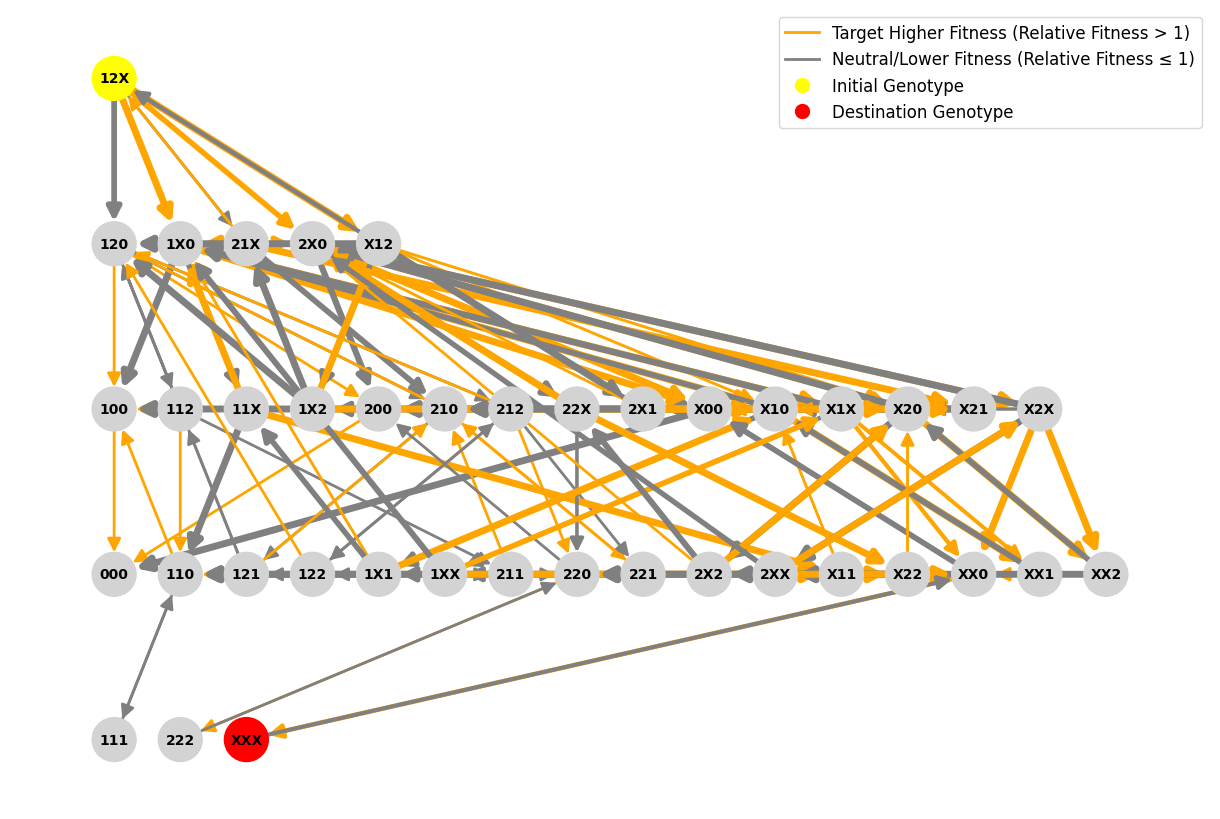

In [138]:

outPath='%s_Amax'%(file_name_figures)
visualize_accessibility_tree_with_fitness(
    initial_genotype_label=initial_genotype_label,
    destination_genotype_label=destination_label_drug,
    labels_genotypes=labels_genotypes,
    M=M,
    relative_fitness_matrix=relative_fitness_matrix_drug,
    accessible_genotypes=accessible_genotypes,
    outPath=outPath
)


In [139]:

# Max drug
destination_label_drug = highest_density_drug
all_paths_drug = find_all_paths(accessibility_tree_labels, initial_genotype_label, destination_label_drug)
print(f"All paths from {initial_genotype_label} to {destination_label_drug}:")
for path in all_paths_drug:
    print(" -> ".join(path))

All paths from 12X to XXX:
12X -> 1X0 -> X10 -> XX1 -> XX0 -> XXX
12X -> 1X0 -> X10 -> XX1 -> 1XX -> XX0 -> XXX
12X -> 1X0 -> X10 -> XX1 -> 1XX -> X1X -> XX0 -> XXX
12X -> 1X0 -> 11X -> X11 -> X10 -> XX1 -> XX0 -> XXX
12X -> 1X0 -> 11X -> X11 -> X10 -> XX1 -> 1XX -> XX0 -> XXX
12X -> 1X0 -> 11X -> X11 -> X10 -> XX1 -> 1XX -> X1X -> XX0 -> XXX
12X -> 1X0 -> 11X -> X11 -> 1X1 -> X10 -> XX1 -> XX0 -> XXX
12X -> 1X0 -> 11X -> X11 -> 1X1 -> X10 -> XX1 -> 1XX -> XX0 -> XXX
12X -> 1X0 -> 11X -> X11 -> 1X1 -> X10 -> XX1 -> 1XX -> X1X -> XX0 -> XXX
12X -> 1X0 -> X1X -> X10 -> XX1 -> XX0 -> XXX
12X -> 1X0 -> X1X -> X10 -> XX1 -> 1XX -> XX0 -> XXX
12X -> 1X0 -> X1X -> XX0 -> XXX
12X -> 1X0 -> X1X -> 1XX -> XX0 -> XXX
12X -> 1X0 -> X1X -> XX1 -> XX0 -> XXX
12X -> 1X0 -> X1X -> XX1 -> 1XX -> XX0 -> XXX
12X -> 2X0 -> X20 -> XX2 -> XX0 -> XXX
12X -> 2X0 -> X20 -> XX2 -> 2XX -> XX0 -> XXX
12X -> 2X0 -> X20 -> XX2 -> 2XX -> X2X -> XX0 -> XXX
12X -> 2X0 -> 22X -> X22 -> X20 -> XX2 -> XX0 -> XXX
12X -> 2

In [140]:


#plot_relative_fitness_for_paths(
#    initial_genotype_label=initial_genotype_label,
#    destination_label=destination_label_drug,
#    accessibility_tree=accessibility_tree_labels,
#    labels_genotypes=labels_genotypes,
#    accessible_genotypes=accessible_genotypes,
#    relative_fitness_matrix=relative_fitness_matrix_drug
#)

In [141]:


accessible_paths_drug = find_accessible_paths(
    initial_genotype_label=initial_genotype_label,
    destination_label=destination_label_drug,
    accessibility_tree=accessibility_tree_labels,
    labels_genotypes=labels_genotypes,
    accessible_genotypes=accessible_genotypes,
    relative_fitness_matrix=relative_fitness_matrix_drug
)

# Print the accessible paths
print("Accessible Paths:")
for path in accessible_paths_drug:
    print(" -> ".join(path))

Finding all paths from 12X to XXX...
Total paths found: 497

Checking path 1/497: 12X -> 1X0 -> X10 -> XX1 -> XX0 -> XXX
Relative fitness from 12X to 1X0: 2.00
Relative fitness from 1X0 to X10: 2.00
Relative fitness from X10 to XX1: 2.00
Relative fitness from XX1 to XX0: 1.03
Relative fitness from XX0 to XXX: 1.44
Path 1 is accessible.

Checking path 2/497: 12X -> 1X0 -> X10 -> XX1 -> 1XX -> XX0 -> XXX
Relative fitness from 12X to 1X0: 2.00
Relative fitness from 1X0 to X10: 2.00
Relative fitness from X10 to XX1: 2.00
Relative fitness from XX1 to 1XX: 0.46
Transition from XX1 to 1XX is not accessible (fitness < 1).
Path 2 is not accessible.

Checking path 3/497: 12X -> 1X0 -> X10 -> XX1 -> 1XX -> X1X -> XX0 -> XXX
Relative fitness from 12X to 1X0: 2.00
Relative fitness from 1X0 to X10: 2.00
Relative fitness from X10 to XX1: 2.00
Relative fitness from XX1 to 1XX: 0.46
Transition from XX1 to 1XX is not accessible (fitness < 1).
Path 3 is not accessible.

Checking path 4/497: 12X -> 1X0 ->

Exporting /content/drive/MyDrive/SYNC_Projects/MI/figures/X_aacA37_aacA45/X_aacA37_aacA45_Amax_accessibleNetwork.pdf


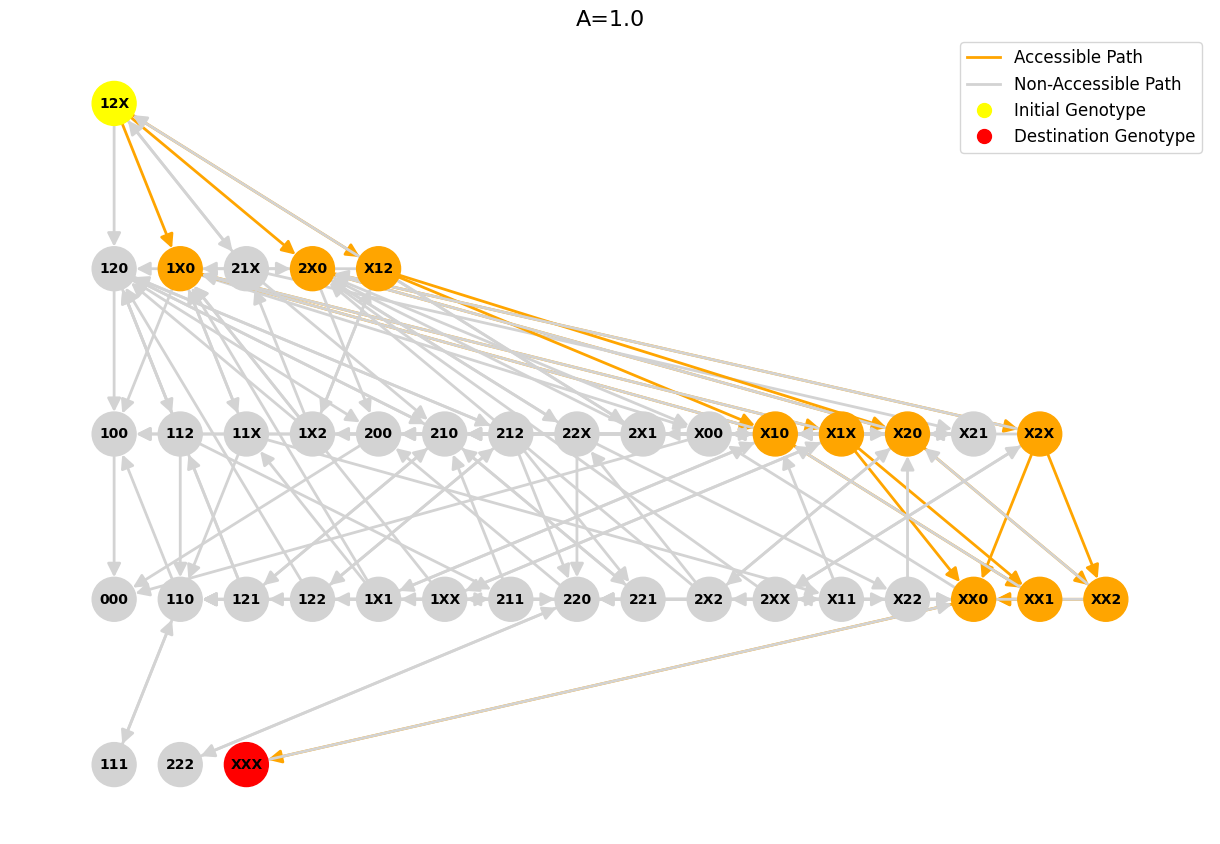

In [142]:


outPath='%s_Amax'%(file_name_figures)
visualize_accessibility_tree_landscape(
    initial_genotype_label=initial_genotype_label,
    destination_genotype_label=destination_label_drug,
    labels_genotypes=labels_genotypes,
    M=M,
    relative_fitness_matrix=relative_fitness_matrix_drug,
    accessible_genotypes=accessible_genotypes,
    accessible_paths=accessible_paths_drug,
    title="A=%s"%max_antibiotic_concentration,
    outPath=outPath
)



Streaming output truncated to the last 5000 lines.
Relative fitness from 1X2 to X12: 2.00
Relative fitness from X12 to 2X1: 0.01
Transition from X12 to 2X1 is not accessible (fitness < 1).
Path 349 is not accessible.

Checking path 350/498: 1X2 -> X12 -> 2X1 -> 2X0 -> 22X -> X22 -> 2X2 -> X20 -> XX2 -> XX0 -> XXX
Relative fitness from 1X2 to X12: 2.00
Relative fitness from X12 to 2X1: 0.01
Transition from X12 to 2X1 is not accessible (fitness < 1).
Path 350 is not accessible.

Checking path 351/498: 1X2 -> X12 -> 2X1 -> 2X0 -> 22X -> X22 -> 2X2 -> X20 -> XX2 -> 2XX -> XX0 -> XXX
Relative fitness from 1X2 to X12: 2.00
Relative fitness from X12 to 2X1: 0.01
Transition from X12 to 2X1 is not accessible (fitness < 1).
Path 351 is not accessible.

Checking path 352/498: 1X2 -> X12 -> 2X1 -> 2X0 -> 22X -> X22 -> 2X2 -> X20 -> XX2 -> 2XX -> X2X -> XX0 -> XXX
Relative fitness from 1X2 to X12: 2.00
Relative fitness from X12 to 2X1: 0.01
Transition from X12 to 2X1 is not accessible (fitness < 1)

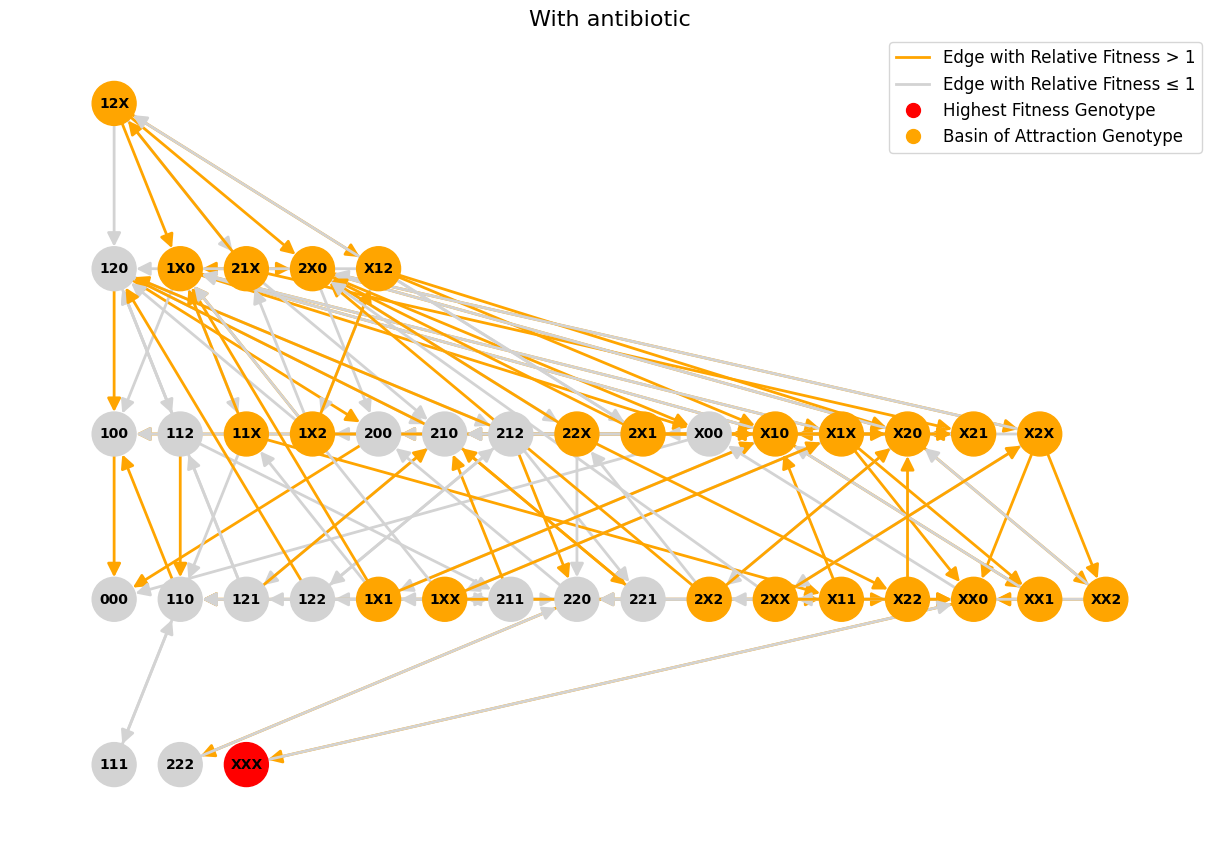

In [143]:


outPath='%s_Amax'%(file_name_figures)

basin_of_attraction_drug = compute_basin_of_attraction(
    initial_genotype_label=initial_genotype_label,
    destination_label=destination_label_drug,
    accessibility_tree=accessibility_tree_labels,
    labels_genotypes=labels_genotypes,
    accessible_genotypes=accessible_genotypes,
    relative_fitness_matrix=relative_fitness_matrix_drug
)


visualize_basin_of_attraction(
    initial_genotype_label=initial_genotype_label,
    destination_genotype_label=destination_label_drug,
    labels_genotypes=labels_genotypes,
    M=M,
    relative_fitness_matrix=relative_fitness_matrix_drug,
    accessible_genotypes=accessible_genotypes,
    basin_of_attraction=basin_of_attraction_drug,
    title="With antibiotic",
    outPath=outPath
)

In [144]:


# Variables to save
data_to_save = {
    "labels_genotypes": labels_genotypes,
    "M_exc": M_exc,
    "M_int": M_int,
    "M": M,
    "accessible_genotypes": accessible_genotypes,
    "initial_genotype_label": initial_genotype_label,
    "highest_density_nodrug": highest_density_nodrug,
    "highest_density_drug": highest_density_drug,
    "all_paths_nodrug": all_paths_nodrug,
    "all_paths_drug": all_paths_drug,
    "accessible_paths_nodrug": accessible_paths_nodrug,
    "accessible_paths_drug": accessible_paths_drug,
    "relative_fitness_matrix_nodrug": relative_fitness_matrix_nodrug,
    "relative_fitness_matrix_drug": relative_fitness_matrix_drug
}

# Save the data to a PKL file
with open(file_name_paths, 'wb') as file:
    pickle.dump(data_to_save, file)

print(f"Paths data successfully saved to {file_name_paths}")


Paths data successfully saved to /content/drive/MyDrive/SYNC_Projects/MI/data/X_aacA37_aacA45/X_aacA37_aacA45_paths.pkl
